In [1]:
# %env TF_CPP_MIN_LOG_LEVEL=3
import sys
import time
from dataclasses import dataclass
import random as r
import numpy as np
from functools import partial
from matplotlib import pyplot as plt
from sentencepiece import SentencePieceProcessor
from concurrent.futures import ProcessPoolExecutor
import os; import glob
import json
import requests
from tqdm import tqdm
from typing import Callable, Sequence

import torch

# Tokenizer

In [2]:
tokenizer_path = "sentence_piece_32000.model"
spm = SentencePieceProcessor(model_file=tokenizer_path)
VOCAB_SIZE = spm.vocab_size(); print(VOCAB_SIZE)
print(spm.Decode(spm.Encode("Hey hi!!!")), spm.Encode("Hey hi!!!"))

32000
Hey hi!!! [18637, 7251, 21004]


# Dataset

In [3]:
DATA_CACHE_DIR = "data"

In [4]:
def download_file(url: str, fname: str, chunk_size=1024):
    """Helper function to download a file from a given url"""
    resp = requests.get(url, stream=True)
    total = int(resp.headers.get("content-length", 0))
    with open(fname, "wb") as file, tqdm(
        desc=fname,
        total=total,
        unit="iB",
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for data in resp.iter_content(chunk_size=chunk_size):
            size = file.write(data)
            bar.update(size)

In [5]:
def download():
    """Downloads the TinyStories dataset to DATA_CACHE_DIR"""
    os.makedirs(DATA_CACHE_DIR, exist_ok=True)

    # download the TinyStories dataset, unless it's already downloaded
    data_url = "https://huggingface.co/datasets/roneneldan/TinyStories/resolve/main/TinyStories_all_data.tar.gz"
    data_filename = os.path.join(DATA_CACHE_DIR, "TinyStories_all_data.tar.gz")
    if not os.path.exists(data_filename):
        print(f"Downloading {data_url} to {data_filename}...")
        download_file(data_url, data_filename)
    else:
        print(f"{data_filename} already exists, skipping download...")

    # unpack the tar.gz file into all the data shards (json files)
    data_dir = os.path.join(DATA_CACHE_DIR, "TinyStories_all_data")
    if not os.path.exists(data_dir):
        os.makedirs(data_dir, exist_ok=True)
        print(f"Unpacking {data_filename}...")
        os.system(f"tar -xzf {data_filename} -C {data_dir}")
    else:
        print(f"{data_dir} already exists, skipping unpacking...")

    # print a single example just for debugging and such
    shard_filenames = sorted(glob.glob(os.path.join(data_dir, "*.json")))
    with open(shard_filenames[0], "r") as f:
        data = json.load(f)
    print("Download done.")
    print(f"Number of shards: {len(shard_filenames)}")
    print(f"Example story:\n{data[0]}")

In [6]:
# download() # ~5mins

In [7]:
def process_shard(args):
    shard_id, shard = args
    with open(shard, "r") as f:
        data = json.load(f)
    all_tokens = []
    for example in tqdm(data, position=shard_id):
        text = example["story"]
        text = text.strip()  # get rid of leading/trailing whitespace
        tokens = spm.Encode(text, bos=True, eos=False)  # encode the text, use BOS
        all_tokens.extend(tokens)
    # convert to uint16 nparray
    all_tokens = np.array(all_tokens, dtype=np.uint16)

    # save .bin files into a new tok{N} directory
    bin_dir = os.path.join(DATA_CACHE_DIR, "tok32000")
    shard_basename = os.path.basename(shard)
    bin_basename = shard_basename.replace(".json", ".bin")
    tokenized_filename = os.path.join(bin_dir, bin_basename)
    
    # write the bytes
    with open(tokenized_filename, "wb") as f:
        f.write(all_tokens.tobytes())

    avg_seq_len = all_tokens.size / ((all_tokens == 1).sum())
    print(f"Saved {tokenized_filename}, average seqlen: {avg_seq_len:.4f}")

In [8]:
def pretokenize():
    # iterate the shards and tokenize all of them one by one
    data_dir = os.path.join(DATA_CACHE_DIR, "TinyStories_all_data")
    shard_filenames = sorted(glob.glob(os.path.join(data_dir, "*.json")))

    # .bin files will be saved into tok{N} directory, create it once here
    bin_dir = os.path.join(DATA_CACHE_DIR, f"tok32000")
    os.makedirs(bin_dir, exist_ok=True)

    # process all the shards in a process pool
    with ProcessPoolExecutor() as executor:
        executor.map(process_shard, enumerate(shard_filenames))
    print("Done Tokenizing.")

In [9]:
# pretokenize()

In [10]:
class PretokDataset(torch.utils.data.IterableDataset):
    """Loads pretokenized examples from disk and yields them as PyTorch tensors."""

    def __init__(self, split, max_seq_len):
        super().__init__()
        self.split = split
        self.max_seq_len = max_seq_len

    def __iter__(self):
        seed = 42
        rng = r.Random(42)
        print(f"Created a PretokDataset with rng seed {seed}")

        # the .bin files are in tok{N} directory
        bin_dir = os.path.join(DATA_CACHE_DIR, "tok32000")
        shard_filenames = sorted(glob.glob(os.path.join(bin_dir, "*.bin")))
        # train/test split. let's use only shard 0 for test split, rest train
        shard_filenames = shard_filenames[1:] if self.split == "train" else shard_filenames[:1]
        assert len(shard_filenames)>0, f"No bin files found in {bin_dir}"
        while True:
            rng.shuffle(shard_filenames)
            for shard in shard_filenames:
                # open the dataset for reading but keep it on disk with memmap
                m = np.memmap(shard, dtype=np.uint16, mode="r")
                num_batches = len(m) // self.max_seq_len
                num_batches -= 1  # drop the last partial batch
                assert num_batches > 0, "this shard is way too small? investigate."
                ixs = list(range(num_batches))
                rng.shuffle(ixs)
                for ix in ixs:
                    start = ix * self.max_seq_len
                    end = start + self.max_seq_len + 1
                    # calling .astype will copy the data into a new numpy array, now in RAM
                    chunk = torch.from_numpy((m[start:end]).astype(np.int64))
                    x = chunk[:-1]
                    y = chunk[1:]
                    yield x, y

In [11]:
class Task:
    @staticmethod
    def iter_batches(batch_size, device="cpu", num_workers=0, **dataset_kwargs):
        ds = PretokDataset(**dataset_kwargs)
        dl = torch.utils.data.DataLoader(
            ds, batch_size=batch_size, pin_memory=False, num_workers=num_workers
        )
        for x, y in dl:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            yield x, y

In [12]:
import jax


In [13]:
from jax import (
    Array,
    numpy as jnp,
    random as jrand
)


In [14]:
import keras as nn
nn.utils.set_random_seed(42) #; nn.mixed_precision.set_dtype_policy("mixed_float16")

2024-03-11 11:08:04.227609: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-11 11:08:04.227670: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-11 11:08:04.253891: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-11 11:08:05.075324: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [15]:
print("Python Version", sys.version); del sys
print(f"Keras Version {nn.__version__} with {nn.backend.backend()} backend \tJax Version {jax.__version__}")
print("Jax backend device", jax.default_backend())
print("Torch Version", torch.__version__)

Python Version 3.11.8 (main, Feb 25 2024, 16:39:33) [GCC 11.4.0]
Keras Version 3.0.4 with jax backend 	Jax Version 0.4.23
Jax backend device gpu
Torch Version 2.2.1+cpu


# Positional Embeddings

In [16]:
class PositionalEmbedding:
    """```
    Sinusoidal Fixed Positional Embeddings
    Args:
        maxlen:int
        dim:int
    sinusoidal_embeddings: 
        pos_emb: (1, maxlen, dim)
    get_freqs:
        get_freqs: sin_freqs(1, maxlen, 1, dim), cos_freqs(1, maxlen, 1, dim)
    ```"""
    def __init__(self, maxlen:int, dim:int):
        p, i = jnp.meshgrid(jnp.arange(float(maxlen)), jnp.arange(dim/2)*2)
        theta = (p/1e4**(i/dim)).T

        self.pos_emb = jnp.stack([jnp.sin(theta), jnp.cos(theta)], axis=-1)
        self.pos_emb = self.pos_emb.reshape((maxlen, dim))[None] # (1, maxlen, dim)

    def sinusoidal_embeddings(self):
        return self.pos_emb # (1, maxlen, dim)
    
    def get_freqs(self):
        sin_freqs = self.pos_emb[..., None, ::2].repeat(2, axis=-1)
        cos_freqs = self.pos_emb[..., None, 1::2].repeat(2, axis=-1)
        return sin_freqs, cos_freqs # (1, maxlen, 1, dim), (1, maxlen, 1, dim)

# GPT

In [17]:
class Attention(nn.Layer):
    """```
    Multi-head Attention
    Args:
        causal:bool
        config
    Input:
        x: shape(B, N, d_model)
        training: bool
    Output:
        linear_att_out: shape(B, N, d_model)
    ```"""
    def __init__(
            self,
            causal:bool,
            config,
            **kwargs
    ):
        super().__init__(**kwargs)
        assert config.d_model % config.num_heads == 0
        self.causal = causal
        self.num_heads = config.num_heads
        self.dim = config.d_model//config.num_heads

        self.wq = nn.layers.Dense(config.d_model, use_bias=False, kernel_initializer=config.intializer(std=0.02))
        self.wk = nn.layers.Dense(config.d_model, use_bias=False, kernel_initializer=config.intializer(std=0.02))
        self.wv = nn.layers.Dense(config.d_model, use_bias=False, kernel_initializer=config.intializer(std=0.02))
        self.attwei_dropout = nn.layers.Dropout(config.dropout_rate)

        self.wo = nn.layers.Dense(
            config.d_model, 
            use_bias=config.use_bias, 
            kernel_initializer=config.intializer(std=0.02/(2*config.num_layers)**0.5)
        )
        if causal:
            self.causal_mask = jnp.triu(jnp.full(shape=(1, 1, config.maxlen, config.maxlen), fill_value=-jnp.inf), k=1)

    def call(
            self,
            x:Array, # (B, T, d_model)
            training:bool
    ):
        B, T, d_model = x.shape

        # compute q, k, v
        q = self.wq(x) # (B, T, d_model)
        k = self.wk(x) # (B, T, d_model)
        v = self.wv(x) # (B, T, d_model)

        # seperate heads
        q = q.reshape((B, self.num_heads, T, self.dim)) # (B, h, T, dim)
        k = k.reshape((B, self.num_heads, T, self.dim)) # (B, h, T, dim)
        v = v.reshape((B, self.num_heads, T, self.dim)) # (B, h, T, dim)

        # compute attention weights
        att_wei = (q @ jnp.matrix_transpose(k))/self.dim**0.5 # (B, h, T, T) <= (B, h, T, dim) @ (B, h, T, dim).transpose(2, 3)
        if self.causal:
            att_wei = att_wei + self.causal_mask[:, :, :T, :T] # (B, h, T, T)

        att_wei = jax.nn.softmax(att_wei, axis=-1) # (B, h, T, T)
        att_wei = self.attwei_dropout(att_wei, training=training)

        # apply attention weights to v
        att_out = att_wei @ v # (B, h, T, T) @ (B, h, T, dv) => (B, h, T, dv)
        # combine heads
        att_out = att_out.reshape((B, T, d_model)) # (B, T, h*dv) ==> (B, T, d_model)

        # linear of att_out
        linear_att_out = self.wo(att_out) # (B, T, d_model)
        return linear_att_out

In [18]:
def build_model(model:nn.Model, input_shape:tuple, val_intervals:tuple):
    blabla = model(
        jrand.randint(jrand.PRNGKey(32344), shape=input_shape, minval=val_intervals[0], maxval=val_intervals[-1]), training=True
    ); del blabla
    return model


class TieWeights(nn.Layer):
    def __init__(self, Layer:nn.Layer, bias_units:int|None|bool, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.Layer = Layer # (1, vocab_size, d_model)
        self.use_bias = bool(bias_units)
        self.activation = nn.layers.Activation(nn.activations.get(activation), dtype=kwargs["dtype"])
        
        if self.use_bias:
            self.bias = self.add_weight(shape=(bias_units,), initializer="zeros", trainable=True)
        
    def call(self, x): # (B, T, d_model)
        W = jnp.array(self.Layer.weights)[0] # (vocab_size, d_model)
        z = x @ jnp.matrix_transpose(W) # (B, T, vocab_size)
        if self.use_bias:
            z += self.bias
        return self.activation(z)


class Block(nn.Model):
    """```
    Block
    Args:
        causal:bool
        config
    Inputs: 
        inputs: shape(B, T, d_model)
        pad_mask: shape(B, T) of boolean dtype
    Outputs:
        outputs: shape(B, T, d_model)
    ```"""
    def __init__(
            self, 
            causal:bool, 
            config,
            **kwargs
    ):
        super().__init__(**kwargs)
        dff_in = 4*config.d_model
        self.norm1 = nn.layers.LayerNormalization(epsilon=1e-5, rms_scaling=not config.use_bias)
        self.mha = Attention(causal, config)

        self.ffn = nn.Sequential([
            nn.layers.Dense(int(dff_in), use_bias=config.use_bias, kernel_initializer=config.intializer(std=0.02)),
            nn.layers.Activation(nn.activations.gelu),
            nn.layers.Dense(config.d_model, use_bias=config.use_bias, kernel_initializer=config.intializer(std=0.02)),
            nn.layers.Dropout(config.dropout_rate)
        ])
        self.norm2 = nn.layers.LayerNormalization(epsilon=1e-5, rms_scaling=not config.use_bias)
        
    def call(self, x:Array, training:bool):
        z = x + self.mha(self.norm1(x), training=training)
        y = z + self.ffn(self.norm2(z), training=training)
        return y # (B, T, d_model)

In [19]:
class GPT(nn.Model):
    """```
    GPT!!
    Args:
        config:
            d_model: int
            num_heads: int
            num_layers: int
            maxlen: int
            vocab_size: int
            output_units: int => if None is equal to vocab_size
            use_bias:bool,
            dropout_rate: float
        causal:bool
        output_activation:str
    Inputs:
        inputs: shape(B, T)
    Outputs: 
        outputs: shape(B, T, d_model)    
    ```"""
    def __init__(self, config, causal:bool, output_activation:str=None, **kwargs):
        super().__init__(**kwargs)
        if config.output_units is None:
            config.output_units = config.vocab_size
        # pos embedding
        self.pos_embed = PositionalEmbedding(config.maxlen, config.d_model).sinusoidal_embeddings() # (1, maxlen, d_model)
        # embedding tokens and dropout
        self.emb_dropout = nn.layers.Dropout(config.dropout_rate)
        self.token_embed = nn.layers.Embedding(
            config.vocab_size, 
            config.d_model,
            embeddings_initializer=config.intializer(std=0.02)
        )

        # block layers
        self.block_layers = [
                Block(
                    causal=causal, 
                    config=config
                ) for _ in range(config.num_layers)
            ]

        # final layer: outputs logits with dropout
        self.norm = nn.layers.LayerNormalization(epsilon=1e-5, rms_scaling=not config.use_bias)
        
        self.linear = TieWeights(
            self.token_embed, 
            bias_units=None if config.use_bias is False else config.output_units, 
            activation=output_activation, 
            dtype="float32"
        )
        self.logits_dropout = nn.layers.Dropout(rate=config.dropout_rate)

    def call(
            self, 
            inputs:Array,
            training=False
    ):
        # embed tokens
        x = self.emb_dropout(
            self.token_embed(inputs)+self.pos_embed[:, :inputs.shape[-1], :], training=training
        ) # (B, T) ==> (B, T, d_model) # (B, T) ==> (B, T, d_model)
        
        # block layers
        for layer in self.block_layers:
            x = layer(x, training=training) # (B, T, d_model) ==> (B, T, d_model)
        x = self.norm(x)

        # linear layer: outputs logits
        logits = self.linear(x) # (B, T, d_model) ==> (B, T, vocab_size)
        return self.logits_dropout(logits)

In [20]:
@dataclass
class GPTArgs:
    """GPT Configuration"""
    d_model:int = 288
    num_layers:int = 6
    num_heads:int = 6
    maxlen:int = 256
    vocab_size:int = VOCAB_SIZE
    output_units:int = None
    assert d_model % 2 == 0
    assert d_model % num_heads == 0
    dropout_rate:float = 0.0
    use_bias:bool = True
    intializer:Callable = lambda std: nn.initializers.RandomNormal(mean=0.0, stddev=std)

GPTArgs()

GPTArgs(d_model=288, num_layers=6, num_heads=6, maxlen=256, vocab_size=32000, output_units=None, dropout_rate=0.0, use_bias=True, intializer=<function GPTArgs.<lambda> at 0x76f317c6dda0>)

# Loss vs Learning Rate

```python
def LossvsLR(): # (B, maxlen)
    model = build_model(
        GPT(GPTArgs, causal=True, ), 
        (2, GPTArgs.max_context_length), 
        (0, GPTArgs.vocab_size-1)
        )
    inputs = jrand.randint(jrand.PRNGKey(32344), shape=(2, GPTArgs.max_context_length+1), minval=0, maxval=GPTArgs.vocab_size-1)

    def get_loss(lr, model, inputs):
        x, y = inputs[:, :-1], inputs[:, 1:]
        model.compile(
            optimizer=nn.optimizers.AdamW(
                learning_rate=lr, beta_1=0.9, beta_2=0.95, clipvalue=1e0, weight_decay=1e-1),
            loss=nn.losses.SparseCategoricalCrossentropy(from_logits=True)
        )
        loss = model.train_on_batch(x=x, y=y)
        return loss.tolist()
    
    lrs = (10**jnp.linspace(-6, -2, 100)).tolist()
    losses = [get_loss(lr, model, inputs) for lr in lrs]
    # losses = jax.vmap(get_loss, in_axes=(None, 0))(model, lrs)
    return lrs, losses

lr, loss = LossvsLR()

plt.figure(figsize=(15,5))
plt.xlabel("Log base10 Learning Rate: Do 10^(x) to get actual learning rate")
plt.ylabel("Loss")
plt.xticks([-6, -5, -4]+jnp.arange(-3.5, -2.0, 0.1).tolist())
plt.plot(jnp.log10(jnp.array(lr)), loss)
plt.show()
print(10**(-3.2)) # -3.3 or -3.2 seems perfect from the figure. lr ~ 0.0006 = 6e-4 # Set as max learning rate
# for min_lr # -4.3010297 or −4.22184875 # See from fig
# on the brick of too small and optimal # Set as min learning rate # As per chinchilla also 0.1*max_lr
# Can even set min_lr as 0
```
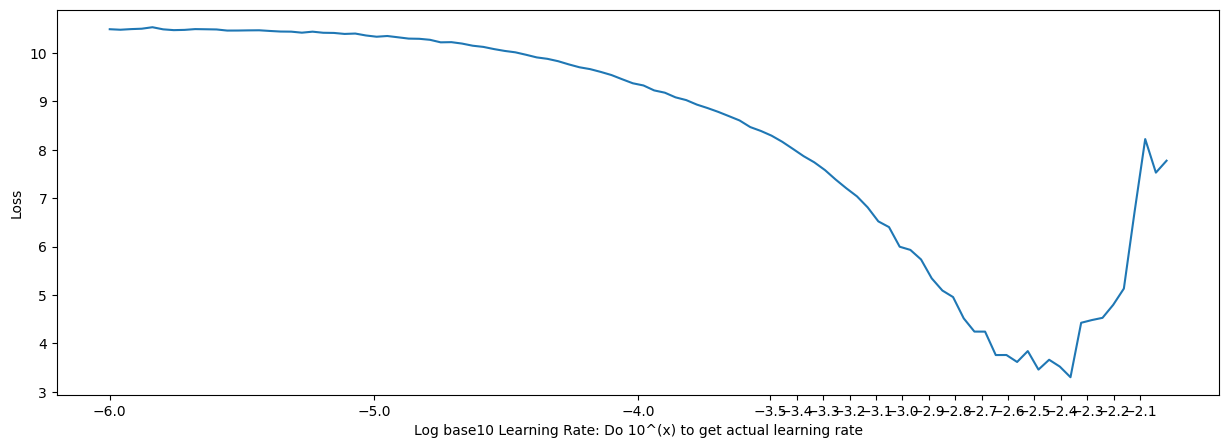

```python
>>>10**jnp.arange(-3.5, -2.0, 0.1), jnp.arange(-3.5, -2.0, 0.1)
(Array([0.00031623, 0.00039811, 0.00050119, 0.00063096, 0.00079433,
        0.001     , 0.00125892, 0.00158489, 0.00199526, 0.00251188,
        0.00316227, 0.00398106, 0.00501186, 0.00630956, 0.00794326],      dtype=float32),
 Array([-3.5      , -3.4      , -3.3000002, -3.2000003, -3.1000004,
        -3.0000005, -2.9000006, -2.8000007, -2.7000008, -2.6000009,
        -2.500001 , -2.400001 , -2.3000011, -2.2000012, -2.1000013],      dtype=float32))
```

# Training Arguments

In [21]:
@dataclass
class TArgs:
    # lr scheduler
    init_lr:float = 1e-7
    max_lr:float = 5e-4
    min_lr:float = 0.0*max_lr # The factor is usually 0.1 or 0.0
    num_steps:int = 100_000
    warmup_steps:int = 1000
    decay_steps:int = num_steps

    # optimizer
    beta1:float = 0.9
    beta2:float = 0.95
    weight_decay:float = 1e-1
    clipnorm:float = 1e0
    num_grad_accumalation_steps:int = 4
    # num_tok_per_update = batch_size * maxlen * gradient_accumalation = 128 * 256 * 4 = 131_072

    # training
    checkpoint_dir:str = "weights/GPTstories"
    checkpoint:str = os.path.join(checkpoint_dir, "Epoch{epoch}.weights.h5")
    eval_freq:int = 2000
    eval_steps:int = 100
    batch_size:int = 128 # micro-mini-batch_size if num_grad_accumalation_steps > 1
    patience:int = 10 # early stopping

TArgs()

TArgs(init_lr=1e-07, max_lr=0.0005, min_lr=0.0, num_steps=100000, warmup_steps=1000, decay_steps=100000, beta1=0.9, beta2=0.95, weight_decay=0.1, clipnorm=1.0, num_grad_accumalation_steps=4, checkpoint_dir='weights/GPTstories', checkpoint='weights/GPTstories/Epoch{epoch}.weights.h5', eval_freq=2000, eval_steps=100, batch_size=128, patience=10)

# Model

In [22]:
model = GPT(GPTArgs, causal=True, output_activation=None)
model = build_model(model, (2, GPTArgs.maxlen), (0, GPTArgs.vocab_size-1))
model.summary()

2024-03-11 11:08:06.014499: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Model: "gpt"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ dropout (Dropout)               │ ?                         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ embedding (Embedding)           │ ?                         │  9,216,000 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block (Block)                   │ ?                         │    998,208 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block_1 (Block)                 │ ?                         │    998,208 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block_2 (Block)                 │ ?                         │    998,208 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block_3 (Block)                 │ ?                         │    998,208 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block_4 (Block)                 │ ?                         │    998,208 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block_5 (Block)                 │ ?                         │    998,208 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ layer_normalization_12          │ ?                         │        576 │
│ (LayerNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ tie_weights (TieWeights)        │ ?                         │  9,248,000 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_13 (Dropout)            │ ?                         │          0 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 15,237,824 (58.13 MB)

 Trainable params: 15,237,824 (58.13 MB)

 Non-trainable params: 0 (0.00 B)

# Load data

```python
Dataset:
	Number of stories: 2141708
	Number of tokens in the dataset: 508829729
	Number of unique tokens in the dataset: 15350
	Avg length of story: 237.58128045466515
```

In [23]:
data_iterator = partial( # 15,237,824 -> 15,191,712
    Task.iter_batches,
    batch_size=TArgs.batch_size,
    device="cpu",
    max_seq_len=GPTArgs.maxlen, 
)

# Lr schedule

In [24]:
learning_rate = nn.optimizers.schedules.CosineDecay(
    initial_learning_rate=TArgs.init_lr,
    decay_steps=TArgs.decay_steps,
    warmup_steps=TArgs.warmup_steps,
    warmup_target=TArgs.max_lr,
)

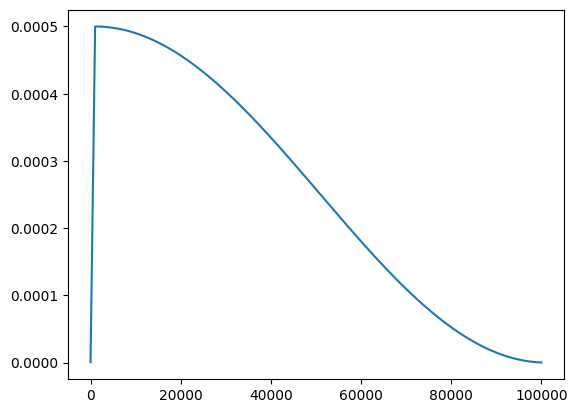

In [25]:
steps = jnp.arange(1, TArgs.num_steps+1)
lrs = jax.vmap(learning_rate)(steps)

plt.plot(steps, lrs); del lrs, steps
plt.show()

# Save and Load states

```python
def save_states(step, state, weights_dir): #checkpoint_dir:str = "weights/GPTstories"
    trainable_variables, non_trainable_variables = state[:-1]

    save_dir = os.path.join(weights_dir, f"Step{step}") # "weights/GPTstories/Step{step}"
    os.makedirs(save_dir)

    np.save(os.path.join(save_dir, "train_vars.npy"), trainable_variables)
    np.save(os.path.join(save_dir, "non_train_vars.npy"), non_trainable_variables)
    return save_dir

def load_states(step, weights_dir):
    load_dir = os.path.join(weights_dir, f"Step{step}")
    
    trainable_variables = np.load(os.path.join(load_dir, "train_vars.npy"))
    non_trainable_variables = np.load(os.path.join(load_dir, "non_train_vars.npy"))
    return trainable_variables.tolist(), non_trainable_variables.tolist()
```

# Training

In [26]:
train_iterator = data_iterator(split="train")
val_iterator = data_iterator(split="val")

In [27]:
optimizer = (
    nn.optimizers.AdamW(
        learning_rate=learning_rate,
        beta_1=TArgs.beta1,
        beta_2=TArgs.beta2,
        clipnorm=TArgs.clipnorm,
        weight_decay=TArgs.weight_decay
    )
)
loss_fn = nn.losses.SparseCategoricalCrossentropy(from_logits=True)

# @jax.jit
# def get_accuracy(y_true:Array, logits:Array): # (B, T, vocab_size), (B, T)
#     batched_num_correct = (logits.argmax(-1)==y_true).sum(-1)/y_true.shape[-1] # (B,)
#     accuracy = batched_num_correct.mean()
#     return accuracy

@partial(jax.jit, static_argnums=-1)
def compute_loss(trainable_variables:list, non_trainable_variables:list, X_batch:Array, y_batch:Array, num_grad_accumalation_steps:int):
    logits, non_trainable_variables = model.stateless_call(
        trainable_variables,
        non_trainable_variables,
        X_batch
    )
    loss = loss_fn(y_batch, logits) #; accuracy = get_accuracy(y_batch, logits)
    scaled_loss = loss/num_grad_accumalation_steps
    return scaled_loss, non_trainable_variables
grad_fn = jax.value_and_grad(compute_loss, has_aux=True)

@partial(jax.jit, static_argnums=-1)
def train_step(state:Sequence[list], X_batches:Array, y_batches:Array, num_grad_accumalation_steps:int): # (4, B, T), (4, B, T)
    trainable_variables, non_trainable_variables, optimizer_variables = state

    grads = jax.tree_util.tree_map(jnp.zeros_like, trainable_variables)
    for X_batch, y_batch in zip(X_batches, y_batches):
        (scaled_loss, non_trainable_variables), grad = grad_fn(
            trainable_variables, non_trainable_variables, X_batch, y_batch,
            num_grad_accumalation_steps
        )
        grads = jax.tree_util.tree_map(
            lambda g1, g2: jnp.add(g1, g2), grads, jax.tree_util.tree_map(jnp.asarray, grad)
        ) # sum grads for grad accumation
    
    loss = scaled_loss*num_grad_accumalation_steps # loss from last mini-step

    trainable_variables, optimizer_variables = optimizer.stateless_apply(
        optimizer_variables, grads, trainable_variables # returns updated trainable_variables
    )
    return loss, (trainable_variables, non_trainable_variables, optimizer_variables)

def evaluate(train_state:Sequence[list]):
    trainable_variables, non_trainable_variables = train_state
    mean_losses = []#; mean_accuracies = []
    for eval_batch_iter in [train_iterator, val_iterator]:
        X_batch, y_batch = next(eval_batch_iter)
        losses = jnp.empty(TArgs.eval_steps)
        # accuracies = jnp.empty_like(losses)

        for eval_step in range(TArgs.eval_steps):
            X_batch, y_batch = jnp.array(X_batch), jnp.array(y_batch)
            loss, non_trainable_variables = compute_loss(
                trainable_variables, 
                non_trainable_variables,
                X_batch,
                y_batch,
                1
            )
            losses = losses.at[eval_step].set(loss)
            # accuracies = accuracies.at[eval_step].set(accuracy)
            X_batch, y_batch = next(eval_batch_iter)
        mean_losses.append(losses.mean())
        # mean_accuracies.append(accuracies.mean())
    return mean_losses #, mean_accuracies # ([train_loss, val_loss], [train_accuracy, val_accuracy])

get_train_batches = lambda : zip(*[next(train_iterator) for _ in range(TArgs.num_grad_accumalation_steps)])

def train(return_best_states:bool):
    step = 1; wait = 0
    eval_losses = {"train": [], "val": []}
    training_losses = {"train": []}

    trainable_variables = model.trainable_variables; optimizer.build(trainable_variables)
    non_trainable_variables = model.non_trainable_variables
    optimizer_variables = optimizer.variables

    best_step = 1
    best_train_state = (trainable_variables, non_trainable_variables)
    best_val_loss = 1e8

    t0 = time.time()
    X_batches, y_batches = get_train_batches()
    while True:
        # condition to terminate
        if step > TArgs.num_steps or wait > TArgs.patience:
            print(f"Early Stopping at Step {step}." if wait > TArgs.patience else "Training Terminated.")
            break

        # train
        loss, (trainable_variables, non_trainable_variables, optimizer_variables) = train_step(
            (trainable_variables, non_trainable_variables, optimizer_variables),
            jnp.array(X_batches), jnp.array(y_batches), TArgs.num_grad_accumalation_steps
        )                

        if step % TArgs.eval_freq == 0 or step == TArgs.num_steps:
            print("Estimating Losses...")
            eval_train_loss, eval_val_loss = evaluate((trainable_variables, non_trainable_variables))
            print(
                f"\t| Training Loss: {eval_train_loss} |"#| Training Accuracy: {eval_train_accuracy} |" 
                f"| Validation Loss: {eval_val_loss} |"#| Validation Accuracy: {eval_val_accuracy} |"
            )

            eval_losses["train"].append(eval_train_loss)
            eval_losses["val"].append(eval_val_loss)

            print("Saved Weights...")

            if eval_losses["val"][-1] < best_val_loss:
                best_val_loss = eval_losses["val"][-1]
                best_train_state = (trainable_variables, non_trainable_variables)
                best_step = step
                wait = 0
            else:
                wait += 1

        # time logging
        t1 = time.time()
        dt = t1-t0; t0 = t1

        # print the essentials
        print(
            f"| Step: {step} || Loss: {loss:.4f} |"#| Accuracy: {accuracy:.4f} |"
            f"| LR: {learning_rate(step):e} || dt: {dt*1000:.2f}ms |"
        )
        training_losses["train"].append(loss.tolist())
        step += 1
    
    if return_best_states:
        print(f"Best Weights are from Step {best_step}...")
        print("With an Estimated Validation Loss of", best_val_loss)
        return best_train_state, training_losses

    return (trainable_variables, non_trainable_variables), training_losses

In [28]:
best_train_state, losses = train(return_best_states=True)

Created a PretokDataset with rng seed 42


2024-03-11 11:08:35.448802: W external/tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 44.74GiB (rounded to 48035219712)requested by op 
2024-03-11 11:08:35.449037: W external/tsl/tsl/framework/bfc_allocator.cc:497] **__________________________________________________________________________________________________
2024-03-11 11:08:35.451056: E external/xla/xla/pjrt/pjrt_stream_executor_client.cc:2732] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 48035219464 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:  175.38MiB
              constant allocation:   544.0KiB
        maybe_live_out allocation:  174.38MiB
     preallocated temp allocation:   44.74GiB
  preallocated temp fragmentation:         0B (0.00%)
                 total allocation:   45.08GiB
              total fragmentation:  147.37MiB (0.32%)
Peak buffers:
	Buffer 1:
		Size: 3.91GiB

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 48035219464 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:  175.38MiB
              constant allocation:   544.0KiB
        maybe_live_out allocation:  174.38MiB
     preallocated temp allocation:   44.74GiB
  preallocated temp fragmentation:         0B (0.00%)
                 total allocation:   45.08GiB
              total fragmentation:  147.37MiB (0.32%)
Peak buffers:
	Buffer 1:
		Size: 3.91GiB
		Operator: op_name="jit(train_step)/jit(main)/transpose(jvp(jit(compute_loss)))/reduce_sum[axes=(0, 1)]" source_file="/tmp/ipykernel_8155/1320795045.py" source_line=22
		XLA Label: fusion
		Shape: f32[128,256,32000]
		==========================

	Buffer 2:
		Size: 3.91GiB
		Operator: op_name="jit(train_step)/jit(main)/transpose(jvp(jit(compute_loss)))/reduce_sum[axes=(0, 1)]" source_file="/tmp/ipykernel_8155/1320795045.py" source_line=22
		XLA Label: fusion
		Shape: f32[128,256,32000]
		==========================

	Buffer 3:
		Size: 3.91GiB
		Operator: op_name="jit(train_step)/jit(main)/transpose(jvp(jit(compute_loss)))/reduce_sum[axes=(0, 1)]" source_file="/tmp/ipykernel_8155/1320795045.py" source_line=22
		XLA Label: fusion
		Shape: f32[128,256,32000]
		==========================

	Buffer 4:
		Size: 3.91GiB
		Operator: op_name="jit(train_step)/jit(main)/transpose(jvp(jit(compute_loss)))/reduce_sum[axes=(0, 1)]" source_file="/tmp/ipykernel_8155/1320795045.py" source_line=22
		XLA Label: fusion
		Shape: f32[128,256,32000]
		==========================

	Buffer 5:
		Size: 3.91GiB
		Operator: op_name="jit(train_step)/jit(main)/jvp(jit(compute_loss))/dot_general[dimension_numbers=(((2,), (0,)), ((), ())) precision=None preferred_element_type=float32]" source_file="/tmp/ipykernel_8155/1320795045.py" source_line=20
		XLA Label: custom-call
		Shape: f32[32768,32000]
		==========================

	Buffer 6:
		Size: 3.91GiB
		Operator: op_name="jit(train_step)/jit(main)/jvp(jit(compute_loss))/dot_general[dimension_numbers=(((2,), (0,)), ((), ())) precision=None preferred_element_type=float32]" source_file="/tmp/ipykernel_8155/1320795045.py" source_line=20
		XLA Label: custom-call
		Shape: f32[32768,32000]
		==========================

	Buffer 7:
		Size: 3.91GiB
		Operator: op_name="jit(train_step)/jit(main)/jvp(jit(compute_loss))/dot_general[dimension_numbers=(((2,), (0,)), ((), ())) precision=None preferred_element_type=float32]" source_file="/tmp/ipykernel_8155/1320795045.py" source_line=20
		XLA Label: custom-call
		Shape: f32[32768,32000]
		==========================

	Buffer 8:
		Size: 3.91GiB
		Operator: op_name="jit(train_step)/jit(main)/jvp(jit(compute_loss))/dot_general[dimension_numbers=(((2,), (0,)), ((), ())) precision=None preferred_element_type=float32]" source_file="/tmp/ipykernel_8155/1320795045.py" source_line=20
		XLA Label: custom-call
		Shape: f32[32768,32000]
		==========================

	Buffer 9:
		Size: 192.00MiB
		Operator: op_name="jit(train_step)/jit(main)/jvp(jit(compute_loss))/reduce_sum[axes=(3,)]" source_file="/tmp/ipykernel_8155/1644889833.py" source_line=60 deduplicated_name="fusion.1823"
		XLA Label: fusion
		Shape: f32[128,6,256,256]
		==========================

	Buffer 10:
		Size: 192.00MiB
		Operator: op_name="jit(train_step)/jit(main)/jvp(jit(compute_loss))/reduce_sum[axes=(3,)]" source_file="/tmp/ipykernel_8155/1644889833.py" source_line=60 deduplicated_name="fusion.1823"
		XLA Label: fusion
		Shape: f32[128,6,256,256]
		==========================

	Buffer 11:
		Size: 192.00MiB
		Operator: op_name="jit(train_step)/jit(main)/jvp(jit(compute_loss))/reduce_sum[axes=(3,)]" source_file="/tmp/ipykernel_8155/1644889833.py" source_line=60 deduplicated_name="fusion.1823"
		XLA Label: fusion
		Shape: f32[128,6,256,256]
		==========================

	Buffer 12:
		Size: 192.00MiB
		Operator: op_name="jit(train_step)/jit(main)/jvp(jit(compute_loss))/reduce_sum[axes=(3,)]" source_file="/tmp/ipykernel_8155/1644889833.py" source_line=60 deduplicated_name="fusion.1823"
		XLA Label: fusion
		Shape: f32[128,6,256,256]
		==========================

	Buffer 13:
		Size: 192.00MiB
		Operator: op_name="jit(train_step)/jit(main)/jvp(jit(compute_loss))/reduce_sum[axes=(3,)]" source_file="/tmp/ipykernel_8155/1644889833.py" source_line=60 deduplicated_name="fusion.1823"
		XLA Label: fusion
		Shape: f32[128,6,256,256]
		==========================

	Buffer 14:
		Size: 192.00MiB
		Operator: op_name="jit(train_step)/jit(main)/jvp(jit(compute_loss))/reduce_sum[axes=(3,)]" source_file="/tmp/ipykernel_8155/1644889833.py" source_line=60 deduplicated_name="fusion.1823"
		XLA Label: fusion
		Shape: f32[128,6,256,256]
		==========================

	Buffer 15:
		Size: 192.00MiB
		Operator: op_name="jit(train_step)/jit(main)/jvp(jit(compute_loss))/reduce_sum[axes=(3,)]" source_file="/tmp/ipykernel_8155/1644889833.py" source_line=60 deduplicated_name="fusion.1823"
		XLA Label: fusion
		Shape: f32[128,6,256,256]
		==========================



In [1]:
a, b = zip(*[(1,2),(3,4),(5,6)])
a, b

((1, 3, 5), (2, 4, 6))

In [2]:
import numpy as np

In [4]:
np.arange(4).reshape(2,2), np.arange(4,8).reshape(2,2)

(array([[0, 1],
        [2, 3]]),
 array([[4, 5],
        [6, 7]]))

In [13]:
import jax

In [16]:
a = np.arange(4).reshape(2,2).tolist()
b = np.arange(4,8).reshape(2,2).tolist()

In [17]:
jax.numpy.add(jnp.array(a), jnp.array(b))

TypeError: add requires ndarray or scalar arguments, got <class 'list'> at position 0.

In [10]:
%timeit sum([np.arange(4).reshape(2,2), np.arange(4,8).reshape(2,2)])

1.48 µs ± 28.4 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [11]:
%timeit np.add(np.arange(4).reshape(2,2), np.arange(4,8).reshape(2,2))

896 ns ± 1.48 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


Created a PretokDataset with rng seed 42
| Step: 1 || Loss: 10.4318 || LR: 5.999001e-07 || dt: 10398.95ms |
| Step: 2 || Loss: 10.4355 || LR: 1.099800e-06 || dt: 2687.50ms |
| Step: 3 || Loss: 10.4328 || LR: 1.599700e-06 || dt: 2671.17ms |
Estimating Losses...


ValueError: INVALID_ARGUMENT: Executable expected 84 arguments but got 85

In [1]:
import jax; jnp = jax.numpy
grads = jnp.array([1,2,3,]); grad = jnp.array([4,5,6])
jax.tree_util.tree_map(lambda x, y: x+y, grads,grad)

2024-03-10 21:46:26.964590: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Array([5, 7, 9], dtype=int32)

In [28]:
%timeit sum(jnp.arange(10_000))

145 ms ± 21.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
from numpy import sum as np_sum

In [29]:
sum(jnp.arange(10_000))

49995000

In [34]:
%timeit jnp.arange(10_000).sum()#.block_until_ready()

42.5 µs ± 295 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [30]:
%timeit np.arange(10_000).sum()#.block_until_ready()                                                         

SyntaxError: invalid syntax (2112286956.py, line 2)

In [27]:
a, b = zip(*[[1,2],[4,5],[6,7],[8,9]])
for ai, bi in zip(a, b):
    print(ai, bi)
jnp.array(a), jnp.array(b)

1 2
4 5
6 7
8 9


(Array([1, 4, 6, 8], dtype=int32), Array([2, 5, 7, 9], dtype=int32))

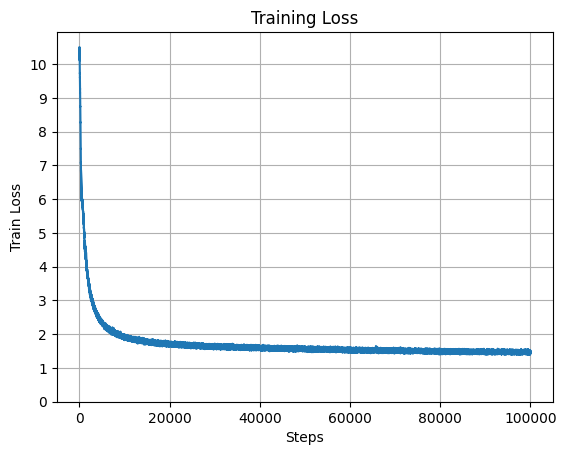

In [30]:
plt.plot(losses["train"])
plt.title("Training Loss")
plt.xlabel("Steps")
plt.ylabel("Train Loss")
plt.yticks(list(range(11)))
plt.grid(True)
plt.show()

# 2,000: 4.13 4.13
# 10,000: 2.18 2.19
# 20,000: 1.96 1.95

# | Validation Loss: 1.848069667816162 | Training Loss: 1.8496700525283813 |
# | Step: 36000 | Loss: 1.8951 | LR: 4.725469e-04| dt: 9636.14ms |

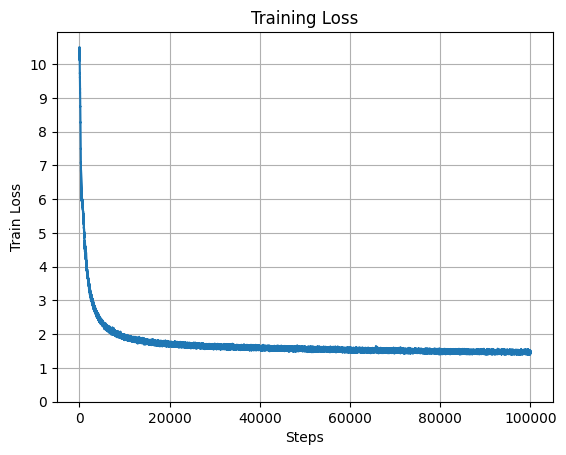

In [ ]:
# 200: 5.54
# 600: 2.34
# 1st eval: train: 1.47 val: 1.47
# 2400: 1.48
# 3226 | loss 1.3816 | lr 4.993765e-04 | 260.28ms | mfu 15.25%

In [ ]:
optimizer = (
    nn.optimizers.AdamW(
        learning_rate=learning_rate,
        beta_1=TArgs.beta1,
        beta_2=TArgs.beta2,
        clipnorm=TArgs.clipnorm,
        weight_decay=TArgs.weight_decay
    )
)
loss_fn = nn.losses.SparseCategoricalCrossentropy(from_logits=True)

# @jax.jit
# def get_accuracy(y_true:Array, logits:Array): # (B, T, vocab_size), (B, T)
#     batched_num_correct = (logits.argmax(-1)==y_true).sum(-1)/y_true.shape[-1] # (B,)
#     accuracy = batched_num_correct.mean()
#     return accuracy

@partial(jax.jit, static_argnums=-1)
def compute_loss(trainable_variables:list, non_trainable_variables:list, X_batch:Array, y_batch:Array, num_grad_accumalation_steps:int):
    logits, non_trainable_variables = model.stateless_call(
        trainable_variables,
        non_trainable_variables,
        X_batch
    )
    loss = loss_fn(y_batch, logits) #; accuracy = get_accuracy(y_batch, logits)
    scaled_loss = loss/num_grad_accumalation_steps
    return (scaled_loss, non_trainable_variables)
grad_fn = jax.value_and_grad(compute_loss, has_aux=True)

@partial(jax.jit, static_argnums=-1)
def mini_train_step(train_state:Sequence[list], X:Array, y:Array, num_grad_accumalation_steps:int):
    trainable_variables, non_trainable_variables = train_state
    (scaled_loss, non_trainable_variables), grad = grad_fn(
            trainable_variables, non_trainable_variables, X, y,
            num_grad_accumalation_steps
        )
    train_state = (trainable_variables, non_trainable_variables)
    return train_state, scaled_loss, grad

def scan_body(state, inputs):
    X_batch, y_batch = inputs
    trainable_variables, non_trainable_variables, optimizer_variables, grads = state

    (trainable_variables, non_trainable_variables), scaled_loss, grad = mini_train_step(
        (trainable_variables, non_trainable_variables),
        X_batch, y_batch, 4
    )

    grads = jax.tree_util.tree_map(lambda *g: sum(g), *(grads, grad))
    state = (trainable_variables, non_trainable_variables, optimizer_variables, grads)
    return state, scaled_loss

def train_step(state, X_batches, y_batches):
    trainable_variables, non_trainable_variables, optimizer_variables = state
    num_grad_accumalation_steps = len(X_batches)
    grads = jax.tree_util.tree_map(jnp.zeros_like, trainable_variables)
    state = (trainable_variables, non_trainable_variables, optimizer_variables, grads)

    state, scaled_losses = jax.lax.scan(scan_body, state, (X_batches, y_batches))
    trainable_variables, non_trainable_variables, optimizer_variables, grads = state

    loss = jnp.mean(scaled_losses * num_grad_accumalation_steps)

    trainable_variables, optimizer_variables = optimizer.stateless_apply(
        optimizer_variables, grads, trainable_variables
    ); del grads

    state = (trainable_variables, non_trainable_variables, optimizer_variables)
    return loss, state

def evaluate(state:tuple[list]):
    trainable_variables, non_trainable_variables = state[:-1]
    mean_losses = []#; mean_accuracies = []
    for eval_batch_iter in [train_iterator, val_iterator]:
        X_batch, y_batch = next(eval_batch_iter)
        losses = jnp.empty(TArgs.eval_steps)
        # accuracies = jnp.empty_like(losses)

        for eval_step in range(TArgs.eval_steps):
            X_batch, y_batch = jnp.array(X_batch), jnp.array(y_batch)
            loss, non_trainable_variables = compute_loss(
                trainable_variables, 
                non_trainable_variables,
                X_batch,
                y_batch,
                1
            )
            losses = losses.at[eval_step].set(loss)
            # accuracies = accuracies.at[eval_step].set(accuracy)
            X_batch, y_batch = next(eval_batch_iter)
        mean_losses.append(losses.mean())
        # mean_accuracies.append(accuracies.mean())
    return mean_losses #, mean_accuracies # ([train_loss, val_loss], [train_accuracy, val_accuracy])

def train(return_best_states:bool):
    step = 1; wait = 0
    eval_losses = {"train": [], "val": []}
    training_losses = {"train": []}

    trainable_variables = model.trainable_variables; optimizer.build(trainable_variables)
    non_trainable_variables = model.non_trainable_variables
    optimizer_variables = optimizer.variables
    state = (trainable_variables, non_trainable_variables, optimizer_variables)

    best_step = 1
    best_state = state
    best_val_loss = 1e8

    t0 = time.time()
    while True:
        # condition to terminate
        if step > TArgs.num_steps or wait > TArgs.patience:
            print(f"Early Stopping at Step {step}." if wait > TArgs.patience else "Training Terminated.")
            break

        # train
        X_batch, y_batch = zip(*[next(train_iterator) for _ in range(TArgs.num_grad_accumalation_steps)])
        loss, state = train_step(state, jnp.array(X_batch), jnp.array(y_batch))

        if step % TArgs.eval_freq == 0:
            print("Estimating Losses...")
            eval_train_loss, eval_val_loss = evaluate(state)
            print(
                f"\t| Training Loss: {eval_train_loss} |"#| Training Accuracy: {eval_train_accuracy} |" 
                f"| Validation Loss: {eval_val_loss} |"#| Validation Accuracy: {eval_val_accuracy} |"
            )

            eval_losses["train"].append(eval_train_loss)
            eval_losses["val"].append(eval_val_loss)

            print("Saved Weights...")

            if eval_losses["val"][-1] < best_val_loss:
                best_val_loss = eval_losses["val"][-1]
                best_state = state
                best_step = step
                wait = 0
            else:
                wait += 1

        # time logging
        t1 = time.time()
        dt = t1-t0; t0 = t1

        # print the essentials
        print(
            f"| Step: {step} || Loss: {loss:.4f} |"#| Accuracy: {accuracy:.4f} |"
            f"| LR: {learning_rate(step):e} || dt: {dt*1000:.2f}ms |"
        )
        training_losses["train"].append(loss.tolist())
        step += 1
    
    if return_best_states:
        print(f"Best Weights are from Step {best_step}...")
        print("With an Estimated Validation Loss of", best_val_loss)
        return best_state[:-1], training_losses

    return state[:-1], training_losses

In [ ]:
# | Step: 200 | Loss: 8.6536 | LR: 1.000800e-04| dt: 152.11ms |
# | Step: 1999 | Loss: 3.7417 | LR: 4.998769e-04| dt: 137.90ms |
# Estimating Losses...
# Created a PretokDataset with rng seed 42
# | Validation Loss: 3.811708688735962 | Training Loss: 3.809429883956909 |

```python
| Step: 1 | Loss: 10.4925 | LR: 5.999001e-07| dt: 8323.02ms |
| Step: 2 | Loss: 10.4874 | LR: 1.099800e-06| dt: 224.19ms |
| Step: 3 | Loss: 10.4965 | LR: 1.599700e-06| dt: 161.27ms |
| Step: 4 | Loss: 10.4883 | LR: 2.099600e-06| dt: 155.62ms |
| Step: 5 | Loss: 10.4921 | LR: 2.599500e-06| dt: 156.70ms |
| Step: 6 | Loss: 10.4919 | LR: 3.099400e-06| dt: 154.55ms |
| Step: 7 | Loss: 10.4919 | LR: 3.599300e-06| dt: 154.54ms |
| Step: 8 | Loss: 10.4959 | LR: 4.099200e-06| dt: 154.26ms |
| Step: 9 | Loss: 10.4860 | LR: 4.599101e-06| dt: 154.47ms |
| Step: 10 | Loss: 10.4916 | LR: 5.099001e-06| dt: 155.19ms |
| Step: 11 | Loss: 10.4924 | LR: 5.598900e-06| dt: 154.77ms |
| Step: 12 | Loss: 10.4851 | LR: 6.098800e-06| dt: 154.14ms |
| Step: 13 | Loss: 10.4798 | LR: 6.598700e-06| dt: 153.74ms |
| Step: 14 | Loss: 10.4743 | LR: 7.098600e-06| dt: 153.40ms |
| Step: 15 | Loss: 10.4742 | LR: 7.598500e-06| dt: 154.34ms |
| Step: 16 | Loss: 10.4794 | LR: 8.098401e-06| dt: 153.47ms |
| Step: 17 | Loss: 10.4597 | LR: 8.598301e-06| dt: 153.62ms |
| Step: 18 | Loss: 10.4659 | LR: 9.098201e-06| dt: 154.33ms |
| Step: 19 | Loss: 10.4614 | LR: 9.598101e-06| dt: 154.54ms |
| Step: 20 | Loss: 10.4682 | LR: 1.009800e-05| dt: 154.37ms |
| Step: 21 | Loss: 10.4492 | LR: 1.059790e-05| dt: 152.82ms |
| Step: 22 | Loss: 10.4486 | LR: 1.109780e-05| dt: 153.22ms |
| Step: 23 | Loss: 10.4517 | LR: 1.159770e-05| dt: 152.86ms |
| Step: 24 | Loss: 10.4433 | LR: 1.209760e-05| dt: 153.06ms |
| Step: 25 | Loss: 10.4333 | LR: 1.259750e-05| dt: 152.90ms |
| Step: 26 | Loss: 10.4269 | LR: 1.309740e-05| dt: 153.26ms |
| Step: 27 | Loss: 10.4208 | LR: 1.359730e-05| dt: 153.99ms |
| Step: 28 | Loss: 10.4288 | LR: 1.409720e-05| dt: 148.98ms |
| Step: 29 | Loss: 10.4015 | LR: 1.459710e-05| dt: 148.10ms |
| Step: 30 | Loss: 10.4005 | LR: 1.509700e-05| dt: 150.42ms |
| Step: 31 | Loss: 10.4050 | LR: 1.559690e-05| dt: 152.20ms |
| Step: 32 | Loss: 10.4015 | LR: 1.609680e-05| dt: 152.33ms |
| Step: 33 | Loss: 10.3667 | LR: 1.659670e-05| dt: 152.14ms |
| Step: 34 | Loss: 10.3645 | LR: 1.709660e-05| dt: 151.39ms |
| Step: 35 | Loss: 10.3727 | LR: 1.759650e-05| dt: 152.24ms |
| Step: 36 | Loss: 10.3731 | LR: 1.809640e-05| dt: 152.27ms |
| Step: 37 | Loss: 10.3301 | LR: 1.859630e-05| dt: 152.24ms |
| Step: 38 | Loss: 10.3377 | LR: 1.909620e-05| dt: 152.07ms |
| Step: 39 | Loss: 10.3352 | LR: 1.959610e-05| dt: 152.84ms |
| Step: 40 | Loss: 10.3358 | LR: 2.009600e-05| dt: 151.27ms |
| Step: 41 | Loss: 10.2942 | LR: 2.059590e-05| dt: 152.16ms |
| Step: 42 | Loss: 10.2969 | LR: 2.109580e-05| dt: 151.89ms |
| Step: 43 | Loss: 10.2905 | LR: 2.159570e-05| dt: 152.06ms |
| Step: 44 | Loss: 10.3006 | LR: 2.209560e-05| dt: 153.44ms |
| Step: 45 | Loss: 10.2530 | LR: 2.259550e-05| dt: 152.04ms |
| Step: 46 | Loss: 10.2492 | LR: 2.309540e-05| dt: 152.35ms |
| Step: 47 | Loss: 10.2516 | LR: 2.359530e-05| dt: 152.27ms |
| Step: 48 | Loss: 10.2486 | LR: 2.409520e-05| dt: 152.12ms |
| Step: 49 | Loss: 10.2019 | LR: 2.459510e-05| dt: 151.88ms |
| Step: 50 | Loss: 10.2001 | LR: 2.509500e-05| dt: 152.08ms |
| Step: 51 | Loss: 10.2015 | LR: 2.559490e-05| dt: 152.28ms |
| Step: 52 | Loss: 10.2026 | LR: 2.609480e-05| dt: 152.40ms |
| Step: 53 | Loss: 10.1606 | LR: 2.659470e-05| dt: 151.28ms |
| Step: 54 | Loss: 10.1522 | LR: 2.709460e-05| dt: 151.70ms |
| Step: 55 | Loss: 10.1549 | LR: 2.759450e-05| dt: 151.48ms |
| Step: 56 | Loss: 10.1576 | LR: 2.809440e-05| dt: 150.96ms |
| Step: 57 | Loss: 10.1187 | LR: 2.859430e-05| dt: 151.47ms |
| Step: 58 | Loss: 10.1099 | LR: 2.909420e-05| dt: 151.35ms |
| Step: 59 | Loss: 10.1098 | LR: 2.959410e-05| dt: 151.55ms |
| Step: 60 | Loss: 10.1153 | LR: 3.009400e-05| dt: 152.43ms |
| Step: 61 | Loss: 10.0584 | LR: 3.059390e-05| dt: 152.53ms |
| Step: 62 | Loss: 10.0606 | LR: 3.109380e-05| dt: 151.55ms |
| Step: 63 | Loss: 10.0593 | LR: 3.159370e-05| dt: 151.90ms |
| Step: 64 | Loss: 10.0591 | LR: 3.209361e-05| dt: 151.22ms |
| Step: 65 | Loss: 10.0134 | LR: 3.259350e-05| dt: 151.94ms |
| Step: 66 | Loss: 10.0126 | LR: 3.309340e-05| dt: 151.18ms |
| Step: 67 | Loss: 10.0051 | LR: 3.359330e-05| dt: 151.89ms |
| Step: 68 | Loss: 10.0124 | LR: 3.409321e-05| dt: 152.38ms |
| Step: 69 | Loss: 9.9576 | LR: 3.459310e-05| dt: 151.44ms |
| Step: 70 | Loss: 9.9654 | LR: 3.509300e-05| dt: 151.00ms |
| Step: 71 | Loss: 9.9650 | LR: 3.559290e-05| dt: 150.92ms |
| Step: 72 | Loss: 9.9690 | LR: 3.609281e-05| dt: 151.62ms |
| Step: 73 | Loss: 9.9119 | LR: 3.659270e-05| dt: 151.78ms |
| Step: 74 | Loss: 9.9181 | LR: 3.709260e-05| dt: 151.14ms |
| Step: 75 | Loss: 9.9238 | LR: 3.759250e-05| dt: 151.34ms |
| Step: 76 | Loss: 9.9145 | LR: 3.809241e-05| dt: 151.97ms |
| Step: 77 | Loss: 9.8668 | LR: 3.859230e-05| dt: 151.58ms |
| Step: 78 | Loss: 9.8597 | LR: 3.909220e-05| dt: 150.77ms |
| Step: 79 | Loss: 9.8684 | LR: 3.959211e-05| dt: 151.19ms |
| Step: 80 | Loss: 9.8673 | LR: 4.009201e-05| dt: 152.14ms |
| Step: 81 | Loss: 9.8237 | LR: 4.059190e-05| dt: 151.89ms |
| Step: 82 | Loss: 9.8263 | LR: 4.109180e-05| dt: 151.96ms |
| Step: 83 | Loss: 9.8230 | LR: 4.159171e-05| dt: 151.62ms |
| Step: 84 | Loss: 9.8188 | LR: 4.209161e-05| dt: 152.58ms |
| Step: 85 | Loss: 9.7658 | LR: 4.259150e-05| dt: 151.90ms |
| Step: 86 | Loss: 9.7855 | LR: 4.309140e-05| dt: 151.68ms |
| Step: 87 | Loss: 9.7806 | LR: 4.359131e-05| dt: 151.56ms |
| Step: 88 | Loss: 9.7703 | LR: 4.409120e-05| dt: 151.61ms |
| Step: 89 | Loss: 9.7284 | LR: 4.459110e-05| dt: 152.36ms |
| Step: 90 | Loss: 9.7414 | LR: 4.509100e-05| dt: 151.69ms |
| Step: 91 | Loss: 9.7312 | LR: 4.559091e-05| dt: 151.79ms |
| Step: 92 | Loss: 9.7439 | LR: 4.609080e-05| dt: 152.61ms |
| Step: 93 | Loss: 9.6814 | LR: 4.659070e-05| dt: 152.07ms |
| Step: 94 | Loss: 9.6879 | LR: 4.709061e-05| dt: 144.80ms |
| Step: 95 | Loss: 9.6921 | LR: 4.759051e-05| dt: 140.24ms |
| Step: 96 | Loss: 9.6866 | LR: 4.809040e-05| dt: 141.55ms |
| Step: 97 | Loss: 9.6538 | LR: 4.859030e-05| dt: 142.62ms |
| Step: 98 | Loss: 9.6525 | LR: 4.909021e-05| dt: 141.60ms |
| Step: 99 | Loss: 9.6480 | LR: 4.959011e-05| dt: 141.23ms |
| Step: 100 | Loss: 9.6470 | LR: 5.009000e-05| dt: 141.43ms |
| Step: 101 | Loss: 9.6067 | LR: 5.058990e-05| dt: 144.10ms |
| Step: 102 | Loss: 9.6131 | LR: 5.108981e-05| dt: 141.45ms |
| Step: 103 | Loss: 9.6127 | LR: 5.158971e-05| dt: 141.78ms |
| Step: 104 | Loss: 9.6131 | LR: 5.208960e-05| dt: 139.66ms |
| Step: 105 | Loss: 9.5746 | LR: 5.258950e-05| dt: 139.93ms |
| Step: 106 | Loss: 9.5626 | LR: 5.308941e-05| dt: 140.13ms |
| Step: 107 | Loss: 9.5644 | LR: 5.358931e-05| dt: 140.75ms |
| Step: 108 | Loss: 9.5640 | LR: 5.408920e-05| dt: 139.17ms |
| Step: 109 | Loss: 9.5280 | LR: 5.458911e-05| dt: 142.76ms |
| Step: 110 | Loss: 9.5352 | LR: 5.508901e-05| dt: 140.60ms |
| Step: 111 | Loss: 9.5278 | LR: 5.558891e-05| dt: 140.09ms |
| Step: 112 | Loss: 9.5212 | LR: 5.608880e-05| dt: 139.01ms |
| Step: 113 | Loss: 9.4863 | LR: 5.658871e-05| dt: 140.16ms |
| Step: 114 | Loss: 9.4860 | LR: 5.708861e-05| dt: 140.75ms |
| Step: 115 | Loss: 9.4890 | LR: 5.758851e-05| dt: 138.65ms |
| Step: 116 | Loss: 9.4941 | LR: 5.808840e-05| dt: 140.43ms |
| Step: 117 | Loss: 9.4466 | LR: 5.858831e-05| dt: 140.70ms |
| Step: 118 | Loss: 9.4580 | LR: 5.908821e-05| dt: 141.45ms |
| Step: 119 | Loss: 9.4431 | LR: 5.958811e-05| dt: 142.27ms |
| Step: 120 | Loss: 9.4565 | LR: 6.008800e-05| dt: 140.52ms |
| Step: 121 | Loss: 9.4083 | LR: 6.058791e-05| dt: 141.63ms |
| Step: 122 | Loss: 9.4229 | LR: 6.108781e-05| dt: 140.14ms |
| Step: 123 | Loss: 9.4105 | LR: 6.158771e-05| dt: 141.46ms |
| Step: 124 | Loss: 9.4100 | LR: 6.208761e-05| dt: 140.91ms |
| Step: 125 | Loss: 9.3793 | LR: 6.258750e-05| dt: 143.96ms |
| Step: 126 | Loss: 9.3952 | LR: 6.308741e-05| dt: 142.33ms |
| Step: 127 | Loss: 9.3591 | LR: 6.358731e-05| dt: 138.63ms |
| Step: 128 | Loss: 9.3693 | LR: 6.408721e-05| dt: 142.45ms |
| Step: 129 | Loss: 9.3472 | LR: 6.458711e-05| dt: 142.00ms |
| Step: 130 | Loss: 9.3494 | LR: 6.508701e-05| dt: 140.03ms |
| Step: 131 | Loss: 9.3337 | LR: 6.558691e-05| dt: 146.90ms |
| Step: 132 | Loss: 9.3365 | LR: 6.608680e-05| dt: 145.63ms |
| Step: 133 | Loss: 9.2938 | LR: 6.658670e-05| dt: 142.83ms |
| Step: 134 | Loss: 9.2989 | LR: 6.708661e-05| dt: 141.66ms |
| Step: 135 | Loss: 9.2907 | LR: 6.758651e-05| dt: 143.85ms |
| Step: 136 | Loss: 9.3072 | LR: 6.808641e-05| dt: 139.84ms |
| Step: 137 | Loss: 9.2604 | LR: 6.858631e-05| dt: 142.25ms |
| Step: 138 | Loss: 9.2702 | LR: 6.908621e-05| dt: 142.88ms |
| Step: 139 | Loss: 9.2756 | LR: 6.958611e-05| dt: 142.57ms |
| Step: 140 | Loss: 9.2765 | LR: 7.008600e-05| dt: 143.47ms |
| Step: 141 | Loss: 9.2312 | LR: 7.058591e-05| dt: 140.68ms |
| Step: 142 | Loss: 9.2227 | LR: 7.108581e-05| dt: 140.89ms |
| Step: 143 | Loss: 9.2327 | LR: 7.158571e-05| dt: 142.88ms |
| Step: 144 | Loss: 9.2172 | LR: 7.208561e-05| dt: 142.01ms |
| Step: 145 | Loss: 9.1784 | LR: 7.258551e-05| dt: 143.68ms |
| Step: 146 | Loss: 9.1914 | LR: 7.308541e-05| dt: 140.01ms |
| Step: 147 | Loss: 9.1959 | LR: 7.358530e-05| dt: 141.86ms |
| Step: 148 | Loss: 9.1830 | LR: 7.408520e-05| dt: 140.09ms |
| Step: 149 | Loss: 9.1515 | LR: 7.458511e-05| dt: 140.18ms |
| Step: 150 | Loss: 9.1520 | LR: 7.508501e-05| dt: 141.51ms |
| Step: 151 | Loss: 9.1534 | LR: 7.558491e-05| dt: 142.77ms |
| Step: 152 | Loss: 9.1470 | LR: 7.608481e-05| dt: 141.71ms |
| Step: 153 | Loss: 9.1163 | LR: 7.658471e-05| dt: 141.02ms |
| Step: 154 | Loss: 9.1268 | LR: 7.708461e-05| dt: 141.08ms |
| Step: 155 | Loss: 9.1086 | LR: 7.758450e-05| dt: 142.91ms |
| Step: 156 | Loss: 9.1257 | LR: 7.808441e-05| dt: 142.18ms |
| Step: 157 | Loss: 9.0733 | LR: 7.858431e-05| dt: 145.74ms |
| Step: 158 | Loss: 9.0818 | LR: 7.908421e-05| dt: 142.19ms |
| Step: 159 | Loss: 9.0769 | LR: 7.958411e-05| dt: 143.09ms |
| Step: 160 | Loss: 9.0793 | LR: 8.008401e-05| dt: 141.51ms |
| Step: 161 | Loss: 9.0336 | LR: 8.058391e-05| dt: 142.33ms |
| Step: 162 | Loss: 9.0354 | LR: 8.108380e-05| dt: 143.57ms |
| Step: 163 | Loss: 9.0257 | LR: 8.158370e-05| dt: 144.84ms |
| Step: 164 | Loss: 9.0410 | LR: 8.208361e-05| dt: 142.50ms |
| Step: 165 | Loss: 9.0002 | LR: 8.258351e-05| dt: 140.20ms |
| Step: 166 | Loss: 9.0061 | LR: 8.308341e-05| dt: 141.53ms |
| Step: 167 | Loss: 9.0032 | LR: 8.358331e-05| dt: 142.25ms |
| Step: 168 | Loss: 9.0047 | LR: 8.408321e-05| dt: 140.67ms |
| Step: 169 | Loss: 8.9514 | LR: 8.458311e-05| dt: 143.11ms |
| Step: 170 | Loss: 8.9570 | LR: 8.508300e-05| dt: 142.35ms |
| Step: 171 | Loss: 8.9593 | LR: 8.558291e-05| dt: 142.79ms |
| Step: 172 | Loss: 8.9460 | LR: 8.608281e-05| dt: 140.05ms |
| Step: 173 | Loss: 8.9258 | LR: 8.658271e-05| dt: 142.38ms |
| Step: 174 | Loss: 8.9269 | LR: 8.708261e-05| dt: 142.45ms |
| Step: 175 | Loss: 8.9145 | LR: 8.758251e-05| dt: 144.35ms |
| Step: 176 | Loss: 8.9108 | LR: 8.808241e-05| dt: 151.66ms |
| Step: 177 | Loss: 8.8695 | LR: 8.858230e-05| dt: 152.11ms |
| Step: 178 | Loss: 8.8719 | LR: 8.908220e-05| dt: 152.85ms |
| Step: 179 | Loss: 8.8730 | LR: 8.958211e-05| dt: 153.43ms |
| Step: 180 | Loss: 8.8886 | LR: 9.008201e-05| dt: 153.21ms |
| Step: 181 | Loss: 8.8194 | LR: 9.058191e-05| dt: 151.78ms |
| Step: 182 | Loss: 8.8262 | LR: 9.108181e-05| dt: 154.00ms |
| Step: 183 | Loss: 8.8288 | LR: 9.158171e-05| dt: 153.77ms |
| Step: 184 | Loss: 8.8408 | LR: 9.208161e-05| dt: 152.79ms |
| Step: 185 | Loss: 8.7850 | LR: 9.258150e-05| dt: 152.71ms |
| Step: 186 | Loss: 8.7872 | LR: 9.308141e-05| dt: 155.81ms |
| Step: 187 | Loss: 8.7873 | LR: 9.358131e-05| dt: 152.92ms |
| Step: 188 | Loss: 8.7734 | LR: 9.408121e-05| dt: 153.23ms |
| Step: 189 | Loss: 8.7386 | LR: 9.458111e-05| dt: 152.74ms |
| Step: 190 | Loss: 8.7394 | LR: 9.508101e-05| dt: 153.36ms |
| Step: 191 | Loss: 8.7552 | LR: 9.558092e-05| dt: 153.15ms |
| Step: 192 | Loss: 8.7391 | LR: 9.608080e-05| dt: 152.37ms |
| Step: 193 | Loss: 8.7046 | LR: 9.658070e-05| dt: 153.39ms |
| Step: 194 | Loss: 8.7134 | LR: 9.708061e-05| dt: 152.49ms |
| Step: 195 | Loss: 8.7058 | LR: 9.758051e-05| dt: 153.46ms |
| Step: 196 | Loss: 8.7118 | LR: 9.808041e-05| dt: 153.91ms |
| Step: 197 | Loss: 8.6604 | LR: 9.858031e-05| dt: 153.22ms |
| Step: 198 | Loss: 8.6496 | LR: 9.908021e-05| dt: 153.47ms |
| Step: 199 | Loss: 8.6625 | LR: 9.958012e-05| dt: 152.91ms |
| Step: 200 | Loss: 8.6590 | LR: 1.000800e-04| dt: 152.75ms |
| Step: 201 | Loss: 8.6115 | LR: 1.005799e-04| dt: 152.80ms |
```

## grad accum = 4
```python
Epoch 1/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m261s[0m 124ms/step - accuracy: 0.0676 - loss: 7.6763 - val_accuracy: 0.1971 - val_loss: 4.4651
Epoch 2/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m249s[0m 124ms/step - accuracy: 0.2452 - loss: 4.0874 - val_accuracy: 0.3827 - val_loss: 3.0439
Epoch 3/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m249s[0m 125ms/step - accuracy: 0.4005 - loss: 2.9027 - val_accuracy: 0.4500 - val_loss: 2.5438
Epoch 4/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m249s[0m 125ms/step - accuracy: 0.4596 - loss: 2.4729 - val_accuracy: 0.4830 - val_loss: 2.3128
Epoch 5/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m249s[0m 125ms/step - accuracy: 0.4877 - loss: 2.2768 - val_accuracy: 0.5006 - val_loss: 2.1864
Epoch 6/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m236s[0m 118ms/step - accuracy: 0.5041 - loss: 2.1623 - val_accuracy: 0.5129 - val_loss: 2.1043
Epoch 7/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m248s[0m 124ms/step - accuracy: 0.5147 - loss: 2.0917 - val_accuracy: 0.5207 - val_loss: 2.0533
Epoch 8/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m580s[0m 290ms/step - accuracy: 0.5222 - loss: 2.0435 - val_accuracy: 0.5257 - val_loss: 2.0195
Epoch 9/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m251s[0m 125ms/step - accuracy: 0.5281 - loss: 2.0061 - val_accuracy: 0.5313 - val_loss: 1.9870
Epoch 10/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m248s[0m 124ms/step - accuracy: 0.5324 - loss: 1.9798 - val_accuracy: 0.5349 - val_loss: 1.9644
Epoch 11/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m240s[0m 120ms/step - accuracy: 0.5358 - loss: 1.9586 - val_accuracy: 0.5383 - val_loss: 1.9454
Epoch 12/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m240s[0m 120ms/step - accuracy: 0.5388 - loss: 1.9398 - val_accuracy: 0.5408 - val_loss: 1.9293
Epoch 13/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m240s[0m 120ms/step - accuracy: 0.5420 - loss: 1.9211 - val_accuracy: 0.5443 - val_loss: 1.9099
Epoch 14/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m244s[0m 122ms/step - accuracy: 0.5439 - loss: 1.9100 - val_accuracy: 0.5456 - val_loss: 1.9002
Epoch 15/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m570s[0m 285ms/step - accuracy: 0.5460 - loss: 1.8971 - val_accuracy: 0.5475 - val_loss: 1.8866
Epoch 16/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m240s[0m 120ms/step - accuracy: 0.5482 - loss: 1.8832 - val_accuracy: 0.5487 - val_loss: 1.8809
Epoch 17/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m240s[0m 120ms/step - accuracy: 0.5501 - loss: 1.8715 - val_accuracy: 0.5510 - val_loss: 1.8682
Epoch 18/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m240s[0m 120ms/step - accuracy: 0.5512 - loss: 1.8655 - val_accuracy: 0.5525 - val_loss: 1.8595
Epoch 19/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m241s[0m 121ms/step - accuracy: 0.5525 - loss: 1.8579 - val_accuracy: 0.5525 - val_loss: 1.8571
Epoch 20/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m241s[0m 121ms/step - accuracy: 0.5538 - loss: 1.8514 - val_accuracy: 0.5547 - val_loss: 1.8454
Epoch 21/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m240s[0m 120ms/step - accuracy: 0.5550 - loss: 1.8438 - val_accuracy: 0.5534 - val_loss: 1.8487
Epoch 22/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m241s[0m 121ms/step - accuracy: 0.5565 - loss: 1.8351 - val_accuracy: 0.5564 - val_loss: 1.8349
Epoch 23/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m569s[0m 285ms/step - accuracy: 0.5575 - loss: 1.8290 - val_accuracy: 0.5574 - val_loss: 1.8306
Epoch 24/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m241s[0m 121ms/step - accuracy: 0.5589 - loss: 1.8215 - val_accuracy: 0.5585 - val_loss: 1.8247
Epoch 25/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m241s[0m 120ms/step - accuracy: 0.5595 - loss: 1.8182 - val_accuracy: 0.5591 - val_loss: 1.8206
Epoch 26/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m241s[0m 121ms/step - accuracy: 0.5598 - loss: 1.8157 - val_accuracy: 0.5603 - val_loss: 1.8159
Epoch 27/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m241s[0m 120ms/step - accuracy: 0.5608 - loss: 1.8100 - val_accuracy: 0.5601 - val_loss: 1.8135
Epoch 28/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m241s[0m 120ms/step - accuracy: 0.5614 - loss: 1.8057 - val_accuracy: 0.5611 - val_loss: 1.8069
Epoch 29/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m241s[0m 120ms/step - accuracy: 0.5624 - loss: 1.8008 - val_accuracy: 0.5622 - val_loss: 1.8027
Epoch 30/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m574s[0m 287ms/step - accuracy: 0.5627 - loss: 1.7997 - val_accuracy: 0.5622 - val_loss: 1.8018
Epoch 31/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m240s[0m 120ms/step - accuracy: 0.5639 - loss: 1.7919 - val_accuracy: 0.5640 - val_loss: 1.7935
Epoch 32/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m241s[0m 120ms/step - accuracy: 0.5645 - loss: 1.7880 - val_accuracy: 0.5633 - val_loss: 1.7938
Epoch 33/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m241s[0m 121ms/step - accuracy: 0.5651 - loss: 1.7856 - val_accuracy: 0.5643 - val_loss: 1.7907
Epoch 34/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m241s[0m 120ms/step - accuracy: 0.5651 - loss: 1.7852 - val_accuracy: 0.5651 - val_loss: 1.7861
Epoch 35/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m241s[0m 120ms/step - accuracy: 0.5659 - loss: 1.7804 - val_accuracy: 0.5649 - val_loss: 1.7873
Epoch 36/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m241s[0m 120ms/step - accuracy: 0.5664 - loss: 1.7787 - val_accuracy: 0.5671 - val_loss: 1.7763
Epoch 37/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m241s[0m 120ms/step - accuracy: 0.5670 - loss: 1.7749 - val_accuracy: 0.5669 - val_loss: 1.7754
Epoch 38/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m570s[0m 285ms/step - accuracy: 0.5675 - loss: 1.7712 - val_accuracy: 0.5678 - val_loss: 1.7719
Epoch 39/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m241s[0m 120ms/step - accuracy: 0.5686 - loss: 1.7652 - val_accuracy: 0.5678 - val_loss: 1.7723
Epoch 40/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m240s[0m 120ms/step - accuracy: 0.5687 - loss: 1.7648 - val_accuracy: 0.5676 - val_loss: 1.7726
Epoch 41/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m241s[0m 120ms/step - accuracy: 0.5688 - loss: 1.7647 - val_accuracy: 0.5689 - val_loss: 1.7653
Epoch 42/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m241s[0m 120ms/step - accuracy: 0.5693 - loss: 1.7614 - val_accuracy: 0.5690 - val_loss: 1.7643
Epoch 43/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m241s[0m 121ms/step - accuracy: 0.5699 - loss: 1.7579 - val_accuracy: 0.5702 - val_loss: 1.7588
Epoch 44/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m240s[0m 120ms/step - accuracy: 0.5699 - loss: 1.7584 - val_accuracy: 0.5694 - val_loss: 1.7609
Epoch 45/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m570s[0m 285ms/step - accuracy: 0.5704 - loss: 1.7549 - val_accuracy: 0.5698 - val_loss: 1.7581
Epoch 46/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m239s[0m 119ms/step - accuracy: 0.5718 - loss: 1.7476 - val_accuracy: 0.5706 - val_loss: 1.7560
Epoch 47/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m240s[0m 120ms/step - accuracy: 0.5714 - loss: 1.7494 - val_accuracy: 0.5712 - val_loss: 1.7511
Epoch 48/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m239s[0m 120ms/step - accuracy: 0.5719 - loss: 1.7458 - val_accuracy: 0.5715 - val_loss: 1.7497
Epoch 49/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m241s[0m 120ms/step - accuracy: 0.5725 - loss: 1.7440 - val_accuracy: 0.5720 - val_loss: 1.7477
Epoch 50/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m239s[0m 120ms/step - accuracy: 0.5726 - loss: 1.7437 - val_accuracy: 0.5719 - val_loss: 1.7476
Epoch 51/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m240s[0m 120ms/step - accuracy: 0.5732 - loss: 1.7397 - val_accuracy: 0.5720 - val_loss: 1.7462
Epoch 52/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m240s[0m 120ms/step - accuracy: 0.5733 - loss: 1.7395 - val_accuracy: 0.5724 - val_loss: 1.7434
Epoch 53/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m566s[0m 283ms/step - accuracy: 0.5742 - loss: 1.7342 - val_accuracy: 0.5732 - val_loss: 1.7399
Epoch 54/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m240s[0m 120ms/step - accuracy: 0.5742 - loss: 1.7332 - val_accuracy: 0.5733 - val_loss: 1.7386
Epoch 55/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m240s[0m 120ms/step - accuracy: 0.5744 - loss: 1.7330 - val_accuracy: 0.5741 - val_loss: 1.7353
Epoch 56/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m242s[0m 121ms/step - accuracy: 0.5749 - loss: 1.7297 - val_accuracy: 0.5746 - val_loss: 1.7338
Epoch 57/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m245s[0m 122ms/step - accuracy: 0.5754 - loss: 1.7280 - val_accuracy: 0.5745 - val_loss: 1.7330
Epoch 58/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m239s[0m 119ms/step - accuracy: 0.5760 - loss: 1.7247 - val_accuracy: 0.5750 - val_loss: 1.7294
Epoch 59/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m238s[0m 119ms/step - accuracy: 0.5756 - loss: 1.7264 - val_accuracy: 0.5754 - val_loss: 1.7270
Epoch 60/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m560s[0m 280ms/step - accuracy: 0.5761 - loss: 1.7230 - val_accuracy: 0.5757 - val_loss: 1.7268
Epoch 61/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m243s[0m 122ms/step - accuracy: 0.5770 - loss: 1.7184 - val_accuracy: 0.5759 - val_loss: 1.7251
Epoch 62/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m238s[0m 119ms/step - accuracy: 0.5774 - loss: 1.7165 - val_accuracy: 0.5761 - val_loss: 1.7234
Epoch 63/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m237s[0m 119ms/step - accuracy: 0.5775 - loss: 1.7161 - val_accuracy: 0.5768 - val_loss: 1.7207
Epoch 64/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m238s[0m 119ms/step - accuracy: 0.5776 - loss: 1.7157 - val_accuracy: 0.5773 - val_loss: 1.7178
Epoch 65/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m237s[0m 119ms/step - accuracy: 0.5782 - loss: 1.7125 - val_accuracy: 0.5768 - val_loss: 1.7197
Epoch 66/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m238s[0m 119ms/step - accuracy: 0.5786 - loss: 1.7107 - val_accuracy: 0.5776 - val_loss: 1.7161
Epoch 67/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m237s[0m 119ms/step - accuracy: 0.5786 - loss: 1.7104 - val_accuracy: 0.5776 - val_loss: 1.7164
Epoch 68/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m526s[0m 263ms/step - accuracy: 0.5795 - loss: 1.7053 - val_accuracy: 0.5781 - val_loss: 1.7129
Epoch 69/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m238s[0m 119ms/step - accuracy: 0.5796 - loss: 1.7042 - val_accuracy: 0.5782 - val_loss: 1.7127
Epoch 70/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m237s[0m 119ms/step - accuracy: 0.5799 - loss: 1.7032 - val_accuracy: 0.5786 - val_loss: 1.7102
Epoch 71/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m238s[0m 119ms/step - accuracy: 0.5803 - loss: 1.7009 - val_accuracy: 0.5791 - val_loss: 1.7086
Epoch 72/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m238s[0m 119ms/step - accuracy: 0.5803 - loss: 1.7013 - val_accuracy: 0.5794 - val_loss: 1.7062
Epoch 73/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m238s[0m 119ms/step - accuracy: 0.5809 - loss: 1.6988 - val_accuracy: 0.5796 - val_loss: 1.7050
Epoch 74/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m241s[0m 120ms/step - accuracy: 0.5807 - loss: 1.6987 - val_accuracy: 0.5799 - val_loss: 1.7037
Epoch 75/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m512s[0m 256ms/step - accuracy: 0.5814 - loss: 1.6955 - val_accuracy: 0.5805 - val_loss: 1.7017
Epoch 76/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m233s[0m 117ms/step - accuracy: 0.5821 - loss: 1.6914 - val_accuracy: 0.5804 - val_loss: 1.7002
Epoch 77/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m233s[0m 116ms/step - accuracy: 0.5823 - loss: 1.6905 - val_accuracy: 0.5809 - val_loss: 1.6986
Epoch 78/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m233s[0m 117ms/step - accuracy: 0.5822 - loss: 1.6912 - val_accuracy: 0.5811 - val_loss: 1.6976
Epoch 79/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m233s[0m 117ms/step - accuracy: 0.5825 - loss: 1.6892 - val_accuracy: 0.5814 - val_loss: 1.6961
Epoch 80/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m239s[0m 120ms/step - accuracy: 0.5829 - loss: 1.6879 - val_accuracy: 0.5811 - val_loss: 1.6973
Epoch 81/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m239s[0m 119ms/step - accuracy: 0.5831 - loss: 1.6865 - val_accuracy: 0.5823 - val_loss: 1.6925
Epoch 82/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m465s[0m 232ms/step - accuracy: 0.5834 - loss: 1.6852 - val_accuracy: 0.5825 - val_loss: 1.6907
Epoch 83/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m238s[0m 119ms/step - accuracy: 0.5845 - loss: 1.6784 - val_accuracy: 0.5825 - val_loss: 1.6905
Epoch 84/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m238s[0m 119ms/step - accuracy: 0.5843 - loss: 1.6803 - val_accuracy: 0.5827 - val_loss: 1.6898
Epoch 85/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m239s[0m 119ms/step - accuracy: 0.5847 - loss: 1.6780 - val_accuracy: 0.5826 - val_loss: 1.6890
Epoch 86/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m238s[0m 119ms/step - accuracy: 0.5844 - loss: 1.6799 - val_accuracy: 0.5831 - val_loss: 1.6876
Epoch 87/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m239s[0m 119ms/step - accuracy: 0.5846 - loss: 1.6788 - val_accuracy: 0.5838 - val_loss: 1.6838
Epoch 88/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m238s[0m 119ms/step - accuracy: 0.5850 - loss: 1.6770 - val_accuracy: 0.5840 - val_loss: 1.6831
Epoch 89/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m238s[0m 119ms/step - accuracy: 0.5852 - loss: 1.6757 - val_accuracy: 0.5838 - val_loss: 1.6843
Epoch 90/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m337s[0m 169ms/step - accuracy: 0.5854 - loss: 1.6737 - val_accuracy: 0.5840 - val_loss: 1.6831
Epoch 91/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m238s[0m 119ms/step - accuracy: 0.5858 - loss: 1.6718 - val_accuracy: 0.5841 - val_loss: 1.6820
Epoch 92/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m238s[0m 119ms/step - accuracy: 0.5863 - loss: 1.6698 - val_accuracy: 0.5844 - val_loss: 1.6808
Epoch 93/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m238s[0m 119ms/step - accuracy: 0.5860 - loss: 1.6713 - val_accuracy: 0.5844 - val_loss: 1.6805
Epoch 94/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m238s[0m 119ms/step - accuracy: 0.5863 - loss: 1.6700 - val_accuracy: 0.5845 - val_loss: 1.6804
Epoch 95/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m238s[0m 119ms/step - accuracy: 0.5862 - loss: 1.6705 - val_accuracy: 0.5850 - val_loss: 1.6786
Epoch 96/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m238s[0m 119ms/step - accuracy: 0.5862 - loss: 1.6703 - val_accuracy: 0.5850 - val_loss: 1.6776
Epoch 97/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m238s[0m 119ms/step - accuracy: 0.5861 - loss: 1.6707 - val_accuracy: 0.5847 - val_loss: 1.6796
Epoch 98/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m238s[0m 119ms/step - accuracy: 0.5870 - loss: 1.6658 - val_accuracy: 0.5852 - val_loss: 1.6771
Epoch 99/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m238s[0m 119ms/step - accuracy: 0.5869 - loss: 1.6665 - val_accuracy: 0.5851 - val_loss: 1.6767
Epoch 100/100
[1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m237s[0m 119ms/step - accuracy: 0.5867 - loss: 1.6674 - val_accuracy: 0.5848 - val_loss: 1.6779
Restoring model weights from the end of the best epoch: 99.
```

In [ ]:
# num grad accum = 1
# Epoch 1/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m243s[0m 116ms/step - accuracy: 0.1408 - loss: 6.3299 - val_accuracy: 0.4205 - val_loss: 2.7678
# Epoch 2/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m233s[0m 117ms/step - accuracy: 0.4485 - loss: 2.5633 - val_accuracy: 0.4977 - val_loss: 2.2153
# Epoch 3/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m234s[0m 117ms/step - accuracy: 0.5058 - loss: 2.1608 - val_accuracy: 0.5231 - val_loss: 2.0477
# Epoch 4/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m234s[0m 117ms/step - accuracy: 0.5270 - loss: 2.0229 - val_accuracy: 0.5362 - val_loss: 1.9659
# Epoch 5/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m234s[0m 117ms/step - accuracy: 0.5376 - loss: 1.9563 - val_accuracy: 0.5433 - val_loss: 1.9184
# Epoch 6/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m221s[0m 111ms/step - accuracy: 0.5453 - loss: 1.9085 - val_accuracy: 0.5493 - val_loss: 1.8842
# Epoch 7/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m234s[0m 117ms/step - accuracy: 0.5504 - loss: 1.8770 - val_accuracy: 0.5531 - val_loss: 1.8599
# Epoch 8/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m562s[0m 281ms/step - accuracy: 0.5544 - loss: 1.8518 - val_accuracy: 0.5557 - val_loss: 1.8438
# Epoch 9/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m234s[0m 117ms/step - accuracy: 0.5576 - loss: 1.8332 - val_accuracy: 0.5589 - val_loss: 1.8248
# Epoch 10/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m231s[0m 116ms/step - accuracy: 0.5599 - loss: 1.8196 - val_accuracy: 0.5609 - val_loss: 1.8142
# Epoch 11/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m223s[0m 111ms/step - accuracy: 0.5622 - loss: 1.8059 - val_accuracy: 0.5626 - val_loss: 1.8029
# Epoch 12/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m223s[0m 111ms/step - accuracy: 0.5635 - loss: 1.7975 - val_accuracy: 0.5640 - val_loss: 1.7940
# Epoch 13/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m223s[0m 111ms/step - accuracy: 0.5650 - loss: 1.7900 - val_accuracy: 0.5655 - val_loss: 1.7851
# Epoch 14/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m227s[0m 114ms/step - accuracy: 0.5667 - loss: 1.7797 - val_accuracy: 0.5669 - val_loss: 1.7771
# Epoch 15/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m550s[0m 275ms/step - accuracy: 0.5677 - loss: 1.7737 - val_accuracy: 0.5679 - val_loss: 1.7721
# Epoch 16/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m222s[0m 111ms/step - accuracy: 0.5693 - loss: 1.7638 - val_accuracy: 0.5692 - val_loss: 1.7649
# Epoch 17/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m223s[0m 111ms/step - accuracy: 0.5700 - loss: 1.7595 - val_accuracy: 0.5694 - val_loss: 1.7625
# Epoch 18/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m222s[0m 111ms/step - accuracy: 0.5709 - loss: 1.7555 - val_accuracy: 0.5710 - val_loss: 1.7556
# Epoch 19/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m223s[0m 111ms/step - accuracy: 0.5716 - loss: 1.7513 - val_accuracy: 0.5715 - val_loss: 1.7520
# Epoch 20/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m222s[0m 111ms/step - accuracy: 0.5720 - loss: 1.7477 - val_accuracy: 0.5721 - val_loss: 1.7473
# Epoch 21/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m223s[0m 111ms/step - accuracy: 0.5727 - loss: 1.7439 - val_accuracy: 0.5728 - val_loss: 1.7431
# Epoch 22/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m222s[0m 111ms/step - accuracy: 0.5733 - loss: 1.7412 - val_accuracy: 0.5735 - val_loss: 1.7403
# Epoch 23/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m550s[0m 275ms/step - accuracy: 0.5743 - loss: 1.7351 - val_accuracy: 0.5738 - val_loss: 1.7374
# Epoch 24/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m222s[0m 111ms/step - accuracy: 0.5749 - loss: 1.7312 - val_accuracy: 0.5752 - val_loss: 1.7308
# Epoch 25/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m222s[0m 111ms/step - accuracy: 0.5755 - loss: 1.7281 - val_accuracy: 0.5753 - val_loss: 1.7287
# Epoch 26/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m223s[0m 112ms/step - accuracy: 0.5758 - loss: 1.7264 - val_accuracy: 0.5757 - val_loss: 1.7279
# Epoch 27/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m230s[0m 115ms/step - accuracy: 0.5764 - loss: 1.7233 - val_accuracy: 0.5762 - val_loss: 1.7251
# Epoch 28/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m221s[0m 111ms/step - accuracy: 0.5769 - loss: 1.7199 - val_accuracy: 0.5767 - val_loss: 1.7216
# Epoch 29/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m221s[0m 110ms/step - accuracy: 0.5772 - loss: 1.7193 - val_accuracy: 0.5768 - val_loss: 1.7191
# Epoch 30/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m548s[0m 274ms/step - accuracy: 0.5780 - loss: 1.7140 - val_accuracy: 0.5775 - val_loss: 1.7158
# Epoch 31/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m220s[0m 110ms/step - accuracy: 0.5788 - loss: 1.7090 - val_accuracy: 0.5775 - val_loss: 1.7161
# Epoch 32/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m221s[0m 110ms/step - accuracy: 0.5788 - loss: 1.7089 - val_accuracy: 0.5781 - val_loss: 1.7132
# Epoch 33/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m221s[0m 110ms/step - accuracy: 0.5793 - loss: 1.7067 - val_accuracy: 0.5785 - val_loss: 1.7107
# Epoch 34/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m221s[0m 110ms/step - accuracy: 0.5799 - loss: 1.7033 - val_accuracy: 0.5788 - val_loss: 1.7066
# Epoch 35/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m221s[0m 110ms/step - accuracy: 0.5800 - loss: 1.7026 - val_accuracy: 0.5795 - val_loss: 1.7043
# Epoch 36/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m229s[0m 114ms/step - accuracy: 0.5805 - loss: 1.6999 - val_accuracy: 0.5794 - val_loss: 1.7045
# Epoch 37/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m226s[0m 113ms/step - accuracy: 0.5805 - loss: 1.6992 - val_accuracy: 0.5804 - val_loss: 1.6990
# Epoch 38/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m554s[0m 277ms/step - accuracy: 0.5812 - loss: 1.6957 - val_accuracy: 0.5807 - val_loss: 1.6987
# Epoch 39/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m224s[0m 112ms/step - accuracy: 0.5819 - loss: 1.6916 - val_accuracy: 0.5810 - val_loss: 1.6976
# Epoch 40/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m225s[0m 113ms/step - accuracy: 0.5818 - loss: 1.6918 - val_accuracy: 0.5812 - val_loss: 1.6951
# Epoch 41/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m225s[0m 113ms/step - accuracy: 0.5825 - loss: 1.6876 - val_accuracy: 0.5816 - val_loss: 1.6919
# Epoch 42/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m225s[0m 113ms/step - accuracy: 0.5826 - loss: 1.6876 - val_accuracy: 0.5818 - val_loss: 1.6913
# Epoch 43/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m226s[0m 113ms/step - accuracy: 0.5833 - loss: 1.6849 - val_accuracy: 0.5825 - val_loss: 1.6866
# Epoch 44/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m225s[0m 112ms/step - accuracy: 0.5835 - loss: 1.6828 - val_accuracy: 0.5826 - val_loss: 1.6873
# Epoch 45/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m552s[0m 276ms/step - accuracy: 0.5836 - loss: 1.6818 - val_accuracy: 0.5832 - val_loss: 1.6841
# Epoch 46/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m225s[0m 113ms/step - accuracy: 0.5851 - loss: 1.6738 - val_accuracy: 0.5834 - val_loss: 1.6831
# Epoch 47/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m225s[0m 113ms/step - accuracy: 0.5847 - loss: 1.6759 - val_accuracy: 0.5841 - val_loss: 1.6802
# Epoch 48/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m226s[0m 113ms/step - accuracy: 0.5848 - loss: 1.6758 - val_accuracy: 0.5845 - val_loss: 1.6765
# Epoch 49/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m226s[0m 113ms/step - accuracy: 0.5851 - loss: 1.6731 - val_accuracy: 0.5847 - val_loss: 1.6751
# Epoch 50/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m225s[0m 113ms/step - accuracy: 0.5855 - loss: 1.6716 - val_accuracy: 0.5850 - val_loss: 1.6747
# Epoch 51/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m226s[0m 113ms/step - accuracy: 0.5858 - loss: 1.6704 - val_accuracy: 0.5854 - val_loss: 1.6726
# Epoch 52/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m226s[0m 113ms/step - accuracy: 0.5863 - loss: 1.6676 - val_accuracy: 0.5853 - val_loss: 1.6721
# Epoch 53/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m547s[0m 274ms/step - accuracy: 0.5869 - loss: 1.6638 - val_accuracy: 0.5866 - val_loss: 1.6667
# Epoch 54/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m225s[0m 113ms/step - accuracy: 0.5877 - loss: 1.6598 - val_accuracy: 0.5864 - val_loss: 1.6665
# Epoch 55/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m226s[0m 113ms/step - accuracy: 0.5877 - loss: 1.6597 - val_accuracy: 0.5867 - val_loss: 1.6663
# Epoch 56/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m225s[0m 113ms/step - accuracy: 0.5878 - loss: 1.6595 - val_accuracy: 0.5871 - val_loss: 1.6627
# Epoch 57/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m225s[0m 113ms/step - accuracy: 0.5883 - loss: 1.6564 - val_accuracy: 0.5874 - val_loss: 1.6616
# Epoch 58/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m226s[0m 113ms/step - accuracy: 0.5883 - loss: 1.6564 - val_accuracy: 0.5876 - val_loss: 1.6606
# Epoch 59/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m230s[0m 115ms/step - accuracy: 0.5887 - loss: 1.6540 - val_accuracy: 0.5887 - val_loss: 1.6555
# Epoch 60/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m541s[0m 270ms/step - accuracy: 0.5891 - loss: 1.6522 - val_accuracy: 0.5885 - val_loss: 1.6553
# Epoch 61/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m224s[0m 112ms/step - accuracy: 0.5901 - loss: 1.6467 - val_accuracy: 0.5892 - val_loss: 1.6527
# Epoch 62/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m224s[0m 112ms/step - accuracy: 0.5904 - loss: 1.6445 - val_accuracy: 0.5894 - val_loss: 1.6513
# Epoch 63/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m224s[0m 112ms/step - accuracy: 0.5905 - loss: 1.6447 - val_accuracy: 0.5893 - val_loss: 1.6507
# Epoch 64/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m224s[0m 112ms/step - accuracy: 0.5906 - loss: 1.6441 - val_accuracy: 0.5899 - val_loss: 1.6482
# Epoch 65/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m224s[0m 112ms/step - accuracy: 0.5909 - loss: 1.6428 - val_accuracy: 0.5902 - val_loss: 1.6471
# Epoch 66/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m224s[0m 112ms/step - accuracy: 0.5915 - loss: 1.6397 - val_accuracy: 0.5905 - val_loss: 1.6459
# Epoch 67/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m224s[0m 112ms/step - accuracy: 0.5915 - loss: 1.6392 - val_accuracy: 0.5913 - val_loss: 1.6415
# Epoch 68/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m511s[0m 255ms/step - accuracy: 0.5928 - loss: 1.6324 - val_accuracy: 0.5913 - val_loss: 1.6414
# Epoch 69/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m225s[0m 112ms/step - accuracy: 0.5930 - loss: 1.6315 - val_accuracy: 0.5919 - val_loss: 1.6377
# Epoch 70/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m227s[0m 114ms/step - accuracy: 0.5932 - loss: 1.6308 - val_accuracy: 0.5917 - val_loss: 1.6389
# Epoch 71/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m227s[0m 113ms/step - accuracy: 0.5935 - loss: 1.6290 - val_accuracy: 0.5927 - val_loss: 1.6345
# Epoch 72/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m227s[0m 114ms/step - accuracy: 0.5938 - loss: 1.6279 - val_accuracy: 0.5927 - val_loss: 1.6345
# Epoch 73/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m227s[0m 113ms/step - accuracy: 0.5938 - loss: 1.6272 - val_accuracy: 0.5931 - val_loss: 1.6320
# Epoch 74/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m227s[0m 113ms/step - accuracy: 0.5944 - loss: 1.6242 - val_accuracy: 0.5934 - val_loss: 1.6300
# Epoch 75/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m505s[0m 253ms/step - accuracy: 0.5946 - loss: 1.6228 - val_accuracy: 0.5938 - val_loss: 1.6283
# Epoch 76/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m227s[0m 113ms/step - accuracy: 0.5957 - loss: 1.6167 - val_accuracy: 0.5942 - val_loss: 1.6266
# Epoch 77/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m227s[0m 114ms/step - accuracy: 0.5958 - loss: 1.6173 - val_accuracy: 0.5942 - val_loss: 1.6265
# Epoch 78/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m227s[0m 114ms/step - accuracy: 0.5956 - loss: 1.6178 - val_accuracy: 0.5943 - val_loss: 1.6251
# Epoch 79/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m227s[0m 114ms/step - accuracy: 0.5962 - loss: 1.6148 - val_accuracy: 0.5946 - val_loss: 1.6231
# Epoch 80/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m227s[0m 113ms/step - accuracy: 0.5960 - loss: 1.6157 - val_accuracy: 0.5953 - val_loss: 1.6208
# Epoch 81/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m227s[0m 113ms/step - accuracy: 0.5965 - loss: 1.6131 - val_accuracy: 0.5954 - val_loss: 1.6197
# Epoch 82/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m453s[0m 226ms/step - accuracy: 0.5971 - loss: 1.6098 - val_accuracy: 0.5960 - val_loss: 1.6167
# Epoch 83/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m226s[0m 113ms/step - accuracy: 0.5980 - loss: 1.6049 - val_accuracy: 0.5963 - val_loss: 1.6158
# Epoch 84/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m226s[0m 113ms/step - accuracy: 0.5982 - loss: 1.6052 - val_accuracy: 0.5962 - val_loss: 1.6164
# Epoch 85/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m227s[0m 113ms/step - accuracy: 0.5983 - loss: 1.6040 - val_accuracy: 0.5964 - val_loss: 1.6144
# Epoch 86/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m227s[0m 114ms/step - accuracy: 0.5984 - loss: 1.6034 - val_accuracy: 0.5973 - val_loss: 1.6110
# Epoch 87/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m227s[0m 114ms/step - accuracy: 0.5981 - loss: 1.6052 - val_accuracy: 0.5971 - val_loss: 1.6106
# Epoch 88/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m227s[0m 114ms/step - accuracy: 0.5988 - loss: 1.6018 - val_accuracy: 0.5973 - val_loss: 1.6101
# Epoch 89/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m226s[0m 113ms/step - accuracy: 0.5987 - loss: 1.6021 - val_accuracy: 0.5975 - val_loss: 1.6091
# Epoch 90/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m333s[0m 166ms/step - accuracy: 0.5992 - loss: 1.5993 - val_accuracy: 0.5978 - val_loss: 1.6086
# Epoch 91/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m227s[0m 113ms/step - accuracy: 0.5999 - loss: 1.5959 - val_accuracy: 0.5979 - val_loss: 1.6071
# Epoch 92/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m227s[0m 113ms/step - accuracy: 0.6000 - loss: 1.5955 - val_accuracy: 0.5981 - val_loss: 1.6061
# Epoch 93/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m227s[0m 114ms/step - accuracy: 0.6001 - loss: 1.5948 - val_accuracy: 0.5983 - val_loss: 1.6049
# Epoch 94/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m227s[0m 113ms/step - accuracy: 0.6002 - loss: 1.5941 - val_accuracy: 0.5984 - val_loss: 1.6044
# Epoch 95/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m227s[0m 114ms/step - accuracy: 0.6004 - loss: 1.5935 - val_accuracy: 0.5986 - val_loss: 1.6039
# Epoch 96/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m227s[0m 113ms/step - accuracy: 0.6001 - loss: 1.5946 - val_accuracy: 0.5988 - val_loss: 1.6032
# Epoch 97/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m227s[0m 114ms/step - accuracy: 0.6004 - loss: 1.5937 - val_accuracy: 0.5989 - val_loss: 1.6018
# Epoch 98/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m226s[0m 113ms/step - accuracy: 0.6012 - loss: 1.5884 - val_accuracy: 0.5987 - val_loss: 1.6035
# Epoch 99/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m226s[0m 113ms/step - accuracy: 0.6011 - loss: 1.5886 - val_accuracy: 0.5988 - val_loss: 1.6026
# Epoch 100/100
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m226s[0m 113ms/step - accuracy: 0.6007 - loss: 1.5923 - val_accuracy: 0.5989 - val_loss: 1.6025
# Restoring model weights from the end of the best epoch: 97.


In [ ]:
# Epoch 1/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m544s[0m 263ms/step - accuracy: 0.0729 - loss: 7.4081 - val_accuracy: 0.2381 - val_loss: 4.1504
# Epoch 2/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 116ms/step - accuracy: 0.2793 - loss: 3.8151/home/vvy/.local/lib/python3.11/site-packages/keras/src/backend/jax/trainer.py:535: UserWarning: Your input ran out of data; interrupting epoch. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
#   for step, data in epoch_iterator.enumerate_epoch():
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m238s[0m 119ms/step - accuracy: 0.2793 - loss: 3.8150 - val_accuracy: 0.3854 - val_loss: 3.0200
# Epoch 3/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m265s[0m 132ms/step - accuracy: 0.4030 - loss: 2.8848 - val_accuracy: 0.4482 - val_loss: 2.5547
# Epoch 4/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m231s[0m 116ms/step - accuracy: 0.4574 - loss: 2.4900 - val_accuracy: 0.4804 - val_loss: 2.3290
# Epoch 5/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m259s[0m 129ms/step - accuracy: 0.4863 - loss: 2.2840 - val_accuracy: 0.4990 - val_loss: 2.1966
# Epoch 6/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m232s[0m 116ms/step - accuracy: 0.5037 - loss: 2.1657 - val_accuracy: 0.5120 - val_loss: 2.1103
# Epoch 7/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m258s[0m 129ms/step - accuracy: 0.5149 - loss: 2.0922 - val_accuracy: 0.5205 - val_loss: 2.0546
# Epoch 8/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m516s[0m 258ms/step - accuracy: 0.5227 - loss: 2.0409 - val_accuracy: 0.5271 - val_loss: 2.0143
# Epoch 9/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m258s[0m 129ms/step - accuracy: 0.5286 - loss: 2.0039 - val_accuracy: 0.5320 - val_loss: 1.9839
# Epoch 10/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m231s[0m 116ms/step - accuracy: 0.5330 - loss: 1.9759 - val_accuracy: 0.5360 - val_loss: 1.9609
# Epoch 11/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m268s[0m 134ms/step - accuracy: 0.5369 - loss: 1.9524 - val_accuracy: 0.5381 - val_loss: 1.9421
# Epoch 12/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m234s[0m 117ms/step - accuracy: 0.5395 - loss: 1.9359 - val_accuracy: 0.5413 - val_loss: 1.9262
# Epoch 13/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m260s[0m 130ms/step - accuracy: 0.5426 - loss: 1.9179 - val_accuracy: 0.5433 - val_loss: 1.9095
# Epoch 14/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m236s[0m 118ms/step - accuracy: 0.5450 - loss: 1.9029 - val_accuracy: 0.5457 - val_loss: 1.8998
# Epoch 15/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m545s[0m 272ms/step - accuracy: 0.5471 - loss: 1.8908 - val_accuracy: 0.5480 - val_loss: 1.8859
# Epoch 16/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m226s[0m 113ms/step - accuracy: 0.5497 - loss: 1.8746 - val_accuracy: 0.5497 - val_loss: 1.8754
# Epoch 17/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m254s[0m 127ms/step - accuracy: 0.5513 - loss: 1.8660 - val_accuracy: 0.5520 - val_loss: 1.8625
# Epoch 18/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m226s[0m 113ms/step - accuracy: 0.5526 - loss: 1.8578 - val_accuracy: 0.5536 - val_loss: 1.8512
# Epoch 19/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m253s[0m 126ms/step - accuracy: 0.5544 - loss: 1.8481 - val_accuracy: 0.5542 - val_loss: 1.8487
# Epoch 20/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m226s[0m 113ms/step - accuracy: 0.5556 - loss: 1.8403 - val_accuracy: 0.5570 - val_loss: 1.8358
# Epoch 21/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m253s[0m 126ms/step - accuracy: 0.5574 - loss: 1.8306 - val_accuracy: 0.5572 - val_loss: 1.8323
# Epoch 22/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m236s[0m 118ms/step - accuracy: 0.5587 - loss: 1.8236 - val_accuracy: 0.5579 - val_loss: 1.8248
# Epoch 23/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m524s[0m 262ms/step - accuracy: 0.5600 - loss: 1.8158 - val_accuracy: 0.5607 - val_loss: 1.8133
# Epoch 24/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m229s[0m 114ms/step - accuracy: 0.5611 - loss: 1.8090 - val_accuracy: 0.5609 - val_loss: 1.8128
# Epoch 25/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m264s[0m 132ms/step - accuracy: 0.5619 - loss: 1.8047 - val_accuracy: 0.5616 - val_loss: 1.8057
# Epoch 26/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m240s[0m 120ms/step - accuracy: 0.5631 - loss: 1.7979 - val_accuracy: 0.5626 - val_loss: 1.8017
# Epoch 27/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m269s[0m 134ms/step - accuracy: 0.5641 - loss: 1.7929 - val_accuracy: 0.5640 - val_loss: 1.7931
# Epoch 28/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m230s[0m 115ms/step - accuracy: 0.5648 - loss: 1.7880 - val_accuracy: 0.5655 - val_loss: 1.7841
# Epoch 29/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m252s[0m 126ms/step - accuracy: 0.5658 - loss: 1.7837 - val_accuracy: 0.5654 - val_loss: 1.7850
# Epoch 30/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m462s[0m 231ms/step - accuracy: 0.5669 - loss: 1.7772 - val_accuracy: 0.5669 - val_loss: 1.7774
# Epoch 31/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m253s[0m 126ms/step - accuracy: 0.5683 - loss: 1.7681 - val_accuracy: 0.5676 - val_loss: 1.7733
# Epoch 32/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m227s[0m 113ms/step - accuracy: 0.5690 - loss: 1.7652 - val_accuracy: 0.5683 - val_loss: 1.7693
# Epoch 33/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m256s[0m 128ms/step - accuracy: 0.5696 - loss: 1.7615 - val_accuracy: 0.5695 - val_loss: 1.7631
# Epoch 34/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m232s[0m 116ms/step - accuracy: 0.5705 - loss: 1.7568 - val_accuracy: 0.5695 - val_loss: 1.7623
# Epoch 35/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m259s[0m 130ms/step - accuracy: 0.5713 - loss: 1.7536 - val_accuracy: 0.5707 - val_loss: 1.7562
# Epoch 36/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m232s[0m 116ms/step - accuracy: 0.5718 - loss: 1.7500 - val_accuracy: 0.5716 - val_loss: 1.7535
# Epoch 37/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m259s[0m 130ms/step - accuracy: 0.5726 - loss: 1.7464 - val_accuracy: 0.5723 - val_loss: 1.7477
# Epoch 38/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m383s[0m 191ms/step - accuracy: 0.5734 - loss: 1.7410 - val_accuracy: 0.5729 - val_loss: 1.7443
# Epoch 39/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m259s[0m 129ms/step - accuracy: 0.5746 - loss: 1.7349 - val_accuracy: 0.5732 - val_loss: 1.7422
# Epoch 40/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m232s[0m 116ms/step - accuracy: 0.5750 - loss: 1.7328 - val_accuracy: 0.5749 - val_loss: 1.7351
# Epoch 41/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m258s[0m 129ms/step - accuracy: 0.5757 - loss: 1.7297 - val_accuracy: 0.5749 - val_loss: 1.7343
# Epoch 42/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m228s[0m 114ms/step - accuracy: 0.5764 - loss: 1.7254 - val_accuracy: 0.5753 - val_loss: 1.7304
# Epoch 43/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m254s[0m 127ms/step - accuracy: 0.5768 - loss: 1.7236 - val_accuracy: 0.5757 - val_loss: 1.7294
# Epoch 44/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m227s[0m 114ms/step - accuracy: 0.5772 - loss: 1.7209 - val_accuracy: 0.5761 - val_loss: 1.7269
# Epoch 45/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m322s[0m 161ms/step - accuracy: 0.5776 - loss: 1.7191 - val_accuracy: 0.5767 - val_loss: 1.7249
# Epoch 46/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m227s[0m 114ms/step - accuracy: 0.5786 - loss: 1.7140 - val_accuracy: 0.5775 - val_loss: 1.7214
# Epoch 47/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m254s[0m 127ms/step - accuracy: 0.5790 - loss: 1.7114 - val_accuracy: 0.5776 - val_loss: 1.7202
# Epoch 48/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m227s[0m 114ms/step - accuracy: 0.5792 - loss: 1.7111 - val_accuracy: 0.5775 - val_loss: 1.7193
# Epoch 49/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m256s[0m 128ms/step - accuracy: 0.5793 - loss: 1.7104 - val_accuracy: 0.5780 - val_loss: 1.7177
# Epoch 50/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m226s[0m 113ms/step - accuracy: 0.5794 - loss: 1.7100 - val_accuracy: 0.5779 - val_loss: 1.7191
# Restoring model weights from the end of the best epoch: 49.


# Epoch 1/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m473s[0m 231ms/step - accuracy: 0.0759 - loss: 6.5837 - val_accuracy: 0.2437 - val_loss: 4.1426
# Epoch 2/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m241s[0m 121ms/step - accuracy: 0.2687 - loss: 3.8770 - val_accuracy: 0.3706 - val_loss: 3.1701
# Epoch 3/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m242s[0m 121ms/step - accuracy: 0.3741 - loss: 3.0477 - val_accuracy: 0.4194 - val_loss: 2.8106
# Epoch 4/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m242s[0m 121ms/step - accuracy: 0.4190 - loss: 2.7013 - val_accuracy: 0.4454 - val_loss: 2.6260
# Epoch 5/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m242s[0m 121ms/step - accuracy: 0.4504 - loss: 2.4731 - val_accuracy: 0.4653 - val_loss: 2.4917
# Epoch 6/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m244s[0m 122ms/step - accuracy: 0.4731 - loss: 2.3130 - val_accuracy: 0.4754 - val_loss: 2.4183
# Epoch 7/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m243s[0m 122ms/step - accuracy: 0.4863 - loss: 2.2241 - val_accuracy: 0.4833 - val_loss: 2.3641
# Epoch 8/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m245s[0m 123ms/step - accuracy: 0.5015 - loss: 2.1195 - val_accuracy: 0.4882 - val_loss: 2.3365
# Epoch 9/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m246s[0m 123ms/step - accuracy: 0.5125 - loss: 2.0527 - val_accuracy: 0.4940 - val_loss: 2.2958
# Epoch 10/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m246s[0m 123ms/step - accuracy: 0.5194 - loss: 2.0095 - val_accuracy: 0.4970 - val_loss: 2.2736
# Epoch 11/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m245s[0m 123ms/step - accuracy: 0.5184 - loss: 2.0109 - val_accuracy: 0.5007 - val_loss: 2.2498
# Epoch 12/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m246s[0m 123ms/step - accuracy: 0.5248 - loss: 1.9673 - val_accuracy: 0.5020 - val_loss: 2.2400
# Epoch 13/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m247s[0m 123ms/step - accuracy: 0.5306 - loss: 1.9335 - val_accuracy: 0.5049 - val_loss: 2.2184
# Epoch 14/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m247s[0m 124ms/step - accuracy: 0.5372 - loss: 1.8942 - val_accuracy: 0.5068 - val_loss: 2.2101
# Epoch 15/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m247s[0m 123ms/step - accuracy: 0.5382 - loss: 1.8894 - val_accuracy: 0.5073 - val_loss: 2.2032
# Epoch 16/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m246s[0m 123ms/step - accuracy: 0.5409 - loss: 1.8753 - val_accuracy: 0.5094 - val_loss: 2.1878
# Epoch 17/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m245s[0m 123ms/step - accuracy: 0.5378 - loss: 1.8930 - val_accuracy: 0.5125 - val_loss: 2.1730
# Epoch 18/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m247s[0m 124ms/step - accuracy: 0.5404 - loss: 1.8769 - val_accuracy: 0.5128 - val_loss: 2.1665
# Epoch 19/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m249s[0m 125ms/step - accuracy: 0.5413 - loss: 1.8689 - val_accuracy: 0.5136 - val_loss: 2.1593
# Epoch 20/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m249s[0m 124ms/step - accuracy: 0.5450 - loss: 1.8483 - val_accuracy: 0.5153 - val_loss: 2.1477
# Epoch 21/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m251s[0m 125ms/step - accuracy: 0.5411 - loss: 1.8723 - val_accuracy: 0.5159 - val_loss: 2.1426
# Epoch 22/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m247s[0m 124ms/step - accuracy: 0.5452 - loss: 1.8448 - val_accuracy: 0.5177 - val_loss: 2.1361
# Epoch 23/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m248s[0m 124ms/step - accuracy: 0.5515 - loss: 1.8101 - val_accuracy: 0.5181 - val_loss: 2.1320
# Epoch 24/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m248s[0m 124ms/step - accuracy: 0.5547 - loss: 1.7940 - val_accuracy: 0.5192 - val_loss: 2.1272
# Epoch 25/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m248s[0m 124ms/step - accuracy: 0.5555 - loss: 1.7910 - val_accuracy: 0.5203 - val_loss: 2.1179
# Epoch 26/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m249s[0m 125ms/step - accuracy: 0.5549 - loss: 1.7917 - val_accuracy: 0.5215 - val_loss: 2.1207
# Epoch 27/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m250s[0m 125ms/step - accuracy: 0.5568 - loss: 1.7791 - val_accuracy: 0.5214 - val_loss: 2.1104
# Epoch 28/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m250s[0m 125ms/step - accuracy: 0.5593 - loss: 1.7678 - val_accuracy: 0.5235 - val_loss: 2.1003
# Epoch 29/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m248s[0m 124ms/step - accuracy: 0.5542 - loss: 1.7998 - val_accuracy: 0.5230 - val_loss: 2.0953
# Epoch 30/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m248s[0m 124ms/step - accuracy: 0.5521 - loss: 1.8090 - val_accuracy: 0.5246 - val_loss: 2.0947
# Epoch 31/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m249s[0m 124ms/step - accuracy: 0.5546 - loss: 1.7942 - val_accuracy: 0.5243 - val_loss: 2.0920
# Epoch 32/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m249s[0m 125ms/step - accuracy: 0.5552 - loss: 1.7906 - val_accuracy: 0.5244 - val_loss: 2.0949
# Epoch 33/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m248s[0m 124ms/step - accuracy: 0.5604 - loss: 1.7606 - val_accuracy: 0.5230 - val_loss: 2.0956
# Epoch 34/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m244s[0m 122ms/step - accuracy: 0.5565 - loss: 1.7869 - val_accuracy: 0.5263 - val_loss: 2.0710
# Epoch 35/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m237s[0m 119ms/step - accuracy: 0.5531 - loss: 1.8064 - val_accuracy: 0.5280 - val_loss: 2.0686
# Epoch 36/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m252s[0m 126ms/step - accuracy: 0.5538 - loss: 1.8016 - val_accuracy: 0.5275 - val_loss: 2.0669
# Epoch 37/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m250s[0m 125ms/step - accuracy: 0.5530 - loss: 1.8058 - val_accuracy: 0.5272 - val_loss: 2.0631
# Epoch 38/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m249s[0m 125ms/step - accuracy: 0.5529 - loss: 1.8070 - val_accuracy: 0.5280 - val_loss: 2.0600
# Epoch 39/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m242s[0m 121ms/step - accuracy: 0.5466 - loss: 1.8455 - val_accuracy: 0.5286 - val_loss: 2.0538
# Epoch 40/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m245s[0m 122ms/step - accuracy: 0.5484 - loss: 1.8306 - val_accuracy: 0.5291 - val_loss: 2.0507
# Epoch 41/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m250s[0m 125ms/step - accuracy: 0.5482 - loss: 1.8347 - val_accuracy: 0.5287 - val_loss: 2.0504
# Epoch 42/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m241s[0m 121ms/step - accuracy: 0.5508 - loss: 1.8194 - val_accuracy: 0.5287 - val_loss: 2.0494
# Epoch 43/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m247s[0m 124ms/step - accuracy: 0.5458 - loss: 1.8487 - val_accuracy: 0.5296 - val_loss: 2.0457
# Epoch 44/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m247s[0m 123ms/step - accuracy: 0.5486 - loss: 1.8301 - val_accuracy: 0.5296 - val_loss: 2.0441
# Epoch 45/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m247s[0m 124ms/step - accuracy: 0.5493 - loss: 1.8293 - val_accuracy: 0.5303 - val_loss: 2.0384
# Epoch 46/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m248s[0m 124ms/step - accuracy: 0.5505 - loss: 1.8231 - val_accuracy: 0.5311 - val_loss: 2.0334
# Epoch 47/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m249s[0m 125ms/step - accuracy: 0.5563 - loss: 1.7901 - val_accuracy: 0.5294 - val_loss: 2.0408
# Epoch 48/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m249s[0m 124ms/step - accuracy: 0.5548 - loss: 1.8027 - val_accuracy: 0.5307 - val_loss: 2.0359
# Epoch 49/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m249s[0m 124ms/step - accuracy: 0.5532 - loss: 1.8110 - val_accuracy: 0.5314 - val_loss: 2.0312
# Epoch 50/50
# [1m2000/2000[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m251s[0m 126ms/step - accuracy: 0.5565 - loss: 1.7910 - val_accuracy: 0.5320 - val_loss: 2.0254
# Restoring model weights from the end of the best epoch: 50.

In [ ]:
# DataFrame(
#     {key:value for key, value in history.history.items() if key in ["loss", "val_loss"]}
# ).plot(grid=True, figsize=(8, 5));

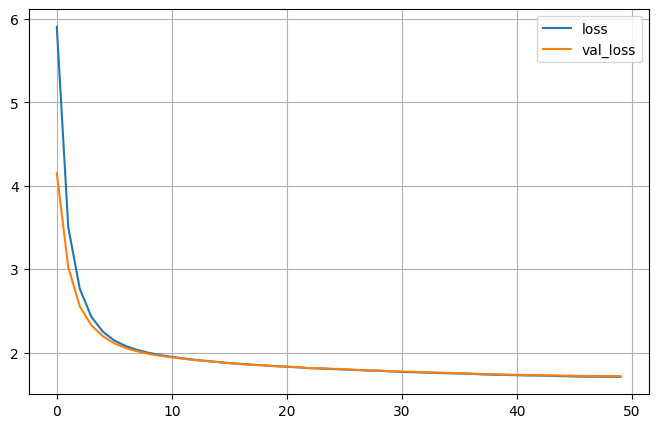

### Without much shuffle
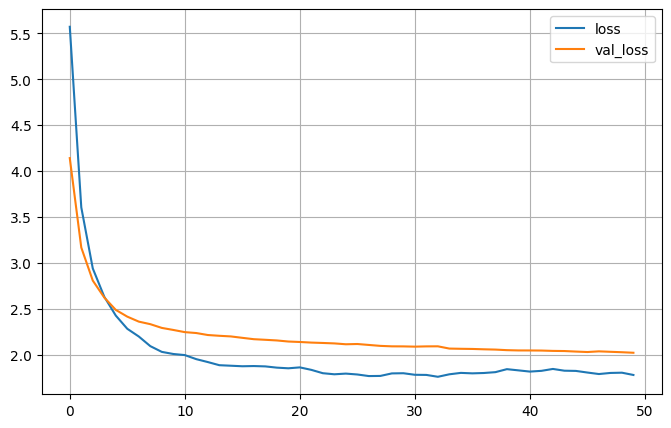

#### Without gradient accumation
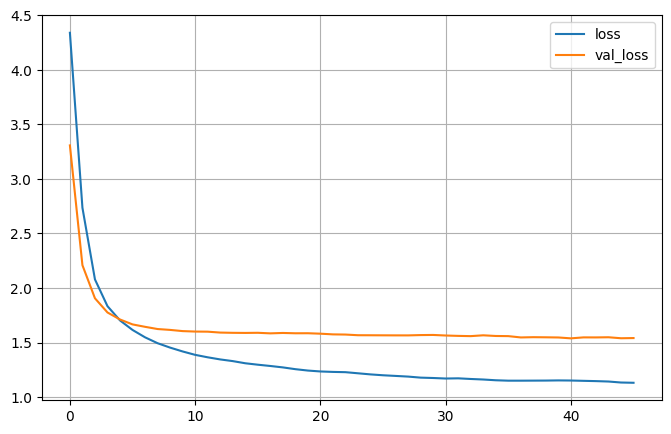

#### With gradient accumation but no clip grad
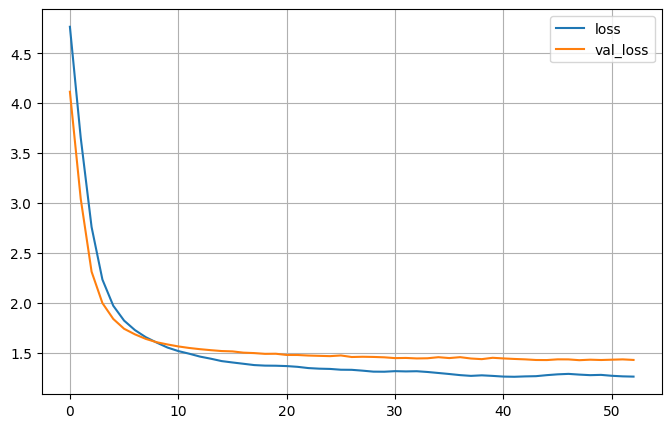

#### With gradient accumation and clip grad

In [ ]:
def sample_top_k(key, logits, k):
    if k==1:
        idx_next = logits.argmax(-1) # (B,)
        return idx_next
    topk_logits, topk_idx = jax.lax.top_k(logits, k=k)
    idx = jrand.categorical(key, topk_logits)
    idx_next = topk_idx[0][idx]
    return idx_next


def generate(idx:Array, max_new_tokens:int, top_k:int|None=None, temperature:float=0.8, seed:int=42):
    if temperature == 0.:
        temperature = top_k = 1
    key = jrand.PRNGKey(seed)
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -GPTArgs.maxlen:] # (B, T)
        logits = model(idx_cond, training=False)[:, -1, :]/temperature # (B, T, vocab_size)[:, -1, :] => (B, vocab_size)
        idx_next = jrand.categorical(key, logits) if top_k is None else sample_top_k(key, logits, k=top_k) # (B,)
        if idx_next == jnp.array(spm.bos_id()):
            break
        key, _ = jrand.split(key)
        idx = jnp.concatenate((idx, idx_next[..., None]), axis=-1) # (B, T+1)
    return idx.tolist()[0]

In [ ]:
print(spm.Decode(generate(idx=jnp.array([[spm.bos_id()]+spm.Encode("Once upon a time,")]), max_new_tokens=500, seed=42, top_k=None)))

In [ ]:
print(spm.Decode(generate(idx=jnp.array([[spm.bos_id()]]), max_new_tokens=500, seed=1221212, top_k=20)))

In [ ]:
print(spm.Decode(generate(idx=jnp.array([[spm.bos_id()]]), max_new_tokens=500, seed=13451, top_k=30)))

In [ ]:
# def train(
#         model:nn.Model,
#         datasets:dict, # {"train": train_ds, "val":val_ds}
#         num_steps:int,
#         eval_freq:int,
#         eval_steps:int,
#         checkpoint_dir:str,
# ):
#     history = {"train": [20], "val":[20]}
#     step = 1
#     for X_batch, y_batch in datasets["train"]:
#         # Evaluate and Checkpointing
#         if step%eval_freq:
#             print(f"Steps: {step}/{num_steps+1}")

#             # estimate model performance
#             losses = evaluate_model(model, datasets, eval_steps)

#             # save weights if better
#             if min(history["val"]) > losses["val"]:
#                 model.save_weights(checkpoint_dir + f'Step{step}_ValLoss{losses["val"]}.weights.h5')

#             # store losses
#             for split in ["train", "val"]:
#                 history[split].append(losses[split])

#         # train model
#         _ = model.train_on_batch(x=X_batch, y=y_batch)
#         step+=1
#     del history["train"][0], history["val"][0]
#     return model, history

# llama, history = train(
#                     llama,
#                     datasets={"train":train_ds, "val":val_ds},
#                     num_steps=TArgs.num_steps,
#                     eval_freq=TArgs.eval_freq,
#                     eval_steps=TArgs.eval_steps,
#                     checkpoint_dir=TArgs.checkpoint_dir
#                 )

In [ ]:
# def train(
#         model:nn.Model,
#         datasets:dict, # {"train": train_ds, "val":val_ds}
#         num_steps:int,
#         eval_freq:int,
#         eval_steps:int,
#         checkpoint_dir:str,
# ):
#     history = {"train": [20], "val":[20]}
#     step = 1
#     for X_batch, y_batch in datasets["train"]:
#         # Evaluate and Checkpointing
#         if step%eval_freq:
#             print(f"Steps: {step}/{num_steps+1}")

#             # estimate model performance
#             losses = evaluate_model(model, datasets, eval_steps)

#             # save weights if better
#             if min(history["val"]) > losses["val"]:
#                 model.save_weights(checkpoint_dir + f'Step{step}_ValLoss{losses["val"]}.weights.h5')

#             # store losses
#             for split in ["train", "val"]:
#                 history[split].append(losses[split])

#         # train model
#         _ = model.train_on_batch(x=X_batch, y=y_batch)
#         step+=1
#     del history["train"][0], history["val"][0]
#     return model, history

# llama, history = train(
#                     llama,
#                     datasets={"train":train_ds, "val":val_ds},
#                     num_steps=TArgs.num_steps,
#                     eval_freq=TArgs.eval_freq,
#                     eval_steps=TArgs.eval_steps,
#                     checkpoint_dir=TArgs.checkpoint_dir
#                 )

In [ ]:
# def generate(idx, max_new_tokens, seed=42):
#     key = jrand.PRNGKey(seed)
#     for _ in range(max_new_tokens):
#         idx_cond = idx[:, -LLaMA_Args.max_context_length:] # (B, T)
#         logits = llama(idx_cond)[:, -1, :] # (B, T, vocab_size)[:, -1, :] => (B, vocab_size)
#         idx_next = jrand.categorical(key, logits)[None] # (B, 1)
#         key, _ = jrand.split(key)
#         idx = jnp.concatenate((idx, idx_next), axis=-1) # (B, T+1)
#     return idx.tolist()[0]

# class DisplayCallback(nn.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs=None):
#         print("\n")
#         print(decode(generate(idx=jnp.array([[0.]]), max_new_tokens=100, seed=42)))
#         print("\n")
#         return

```python
eval_losses = {"train": [], "val":[]}

@partial(jax.jit, static_argnums=(0, 1))
def eval_step(model:nn.Model, loss_fn:nn.Loss, X_batch:Array, y_batch:Array):
    logits = model(X_batch, training=False)
    loss = loss_fn(y_batch, logits)
    return loss

class EvaluateModel(nn.callbacks.Callback):
    def __init__(self, patience):
        super().__init__()
        self.patience = patience
        self.best_val_loss = jnp.inf
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        losses = {"train": [], "val":[]}; print("\n")
        for split in ["val", "train"]:
            for X_batch, y_batch in datasets[split].shuffle(132313, reshuffle_each_iteration=True).take(TArgs.eval_steps).as_numpy_iterator():
                loss = eval_step(model, loss_fn, jnp.array(X_batch), jnp.array(y_batch))
                losses[split].append(loss.tolist())

            eval_losses[split].append(sum(losses[split])/len(losses[split]))
            print(f"\t{split} loss: {eval_losses[split][-1]}")

        latest_val_loss = eval_losses["val"][-1]
        if latest_val_loss < self.best_val_loss:
            self.best_val_loss = latest_val_loss
            self.best_weights = model.get_weights()
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                print(f"Early stopping after {epoch} epochs. Restoring best weights")
                model.stop_training = True
                model.set_weights(self.best_weights)

evaluate_model = EvaluateModel(patience=TArgs.patience)
```

```python
flatten_list = lambda dataset: functools.reduce(operator.iconcat, dataset, [])

def pretokenize_and_save_dataset(ds_path:str, save_dir:str, num_shards:int):
    # load dataset
    dataset = open(ds_path, "r", encoding="utf-8").read() # [...]
    dataset = dataset.split("<|endoftext|>")
    dataset:list = spm.Encode(
            tf.strings.strip(dataset).numpy().tolist(), 
            add_bos=True,
            add_eos=False
        ) # [[SOS story], ..., [SOS story]]
    num_stories = len(dataset)
    print("Dataset:")

    # Flatten list
    dataset = flatten_list(dataset) # [SOS story ... SOS story]
    num_tokens = len(dataset)
    print("\tNumber of stories in the Dataset:", num_stories)
    print("\tNumber of tokens:", num_tokens)
    print("\tNumber of unique tokens:", len(set(dataset)))
    dataset = np.asarray(dataset, dtype=np.uint16)
    print("\tAvg length of story:", num_tokens/((dataset==1).sum()))

    # shard and save dataset
    sharded_datasets_list = np.array_split(dataset, num_shards) # [[SOS story...], [...], [...], ...]
    filenames = [f"{save_dir}shard{i+1}.npy" for i in range(num_shards)]

    for filename, sharded_ds in zip(filenames, sharded_datasets_list):
        with open(filename, "wb") as f:
            np.save(f, sharded_ds)
    return filenames

class DataGen:
    def __init__(self, maxlen:int, batch_size:int, num_shards:int, shard_dir:str, data_path:str|None=None):
        self.maxlen = maxlen
        self.batch_size = batch_size
        if os.path.exists(shard_dir) and os.listdir(shard_dir) :
            filenames = glob.glob(os.path.join(shard_dir, "*.npy"))
        else:
            assert data_path is not None, f"\t{shard_dir} doesn't exist, input the data_path to pretokenize and save"
            os.makedirs(shard_dir)
            filenames = pretokenize_and_save_dataset(data_path, shard_dir, num_shards)
        r.shuffle(filenames)
        num_train_files = round(0.9651*num_shards)
        print(f"\tNumber of files taken for training: {num_train_files}/{num_shards}")
        self.sharded_filenames = {"train":filenames[:num_train_files], "val":filenames[num_train_files:]}
    
    def generate_sequences(self, split):
        r.shuffle(self.sharded_filenames[split])
        for filename in self.sharded_filenames[split]:
            memmaped = np.lib.format.open_memmap(filename, dtype=np.uint16, mode="r")
            batch_idx = list(range(len(memmaped)//self.maxlen))
            r.shuffle(batch_idx)

            for batch in batch_idx:
                start = batch * self.maxlen
                end = start + self.maxlen + 1
                seq = tf.constant(memmaped.astype(np.int32))[start:end]
                yield seq[:-1], seq[1:]
    
    def get_datasets(self):
        train_ds = tf.data.Dataset.from_generator(
            lambda: self.generate_sequences("train"),
            output_signature=(
                tf.TensorSpec(shape=(self.maxlen,), dtype=tf.int32),
                tf.TensorSpec(shape=(self.maxlen,), dtype=tf.int32)
            )
        ).batch(
            self.batch_size, drop_remainder=True, num_parallel_calls=tf.data.AUTOTUNE
        ).repeat().prefetch(tf.data.AUTOTUNE)

        val_ds = tf.data.Dataset.from_generator(
            lambda: self.generate_sequences("val"),
            output_signature=(
                tf.TensorSpec(shape=(self.maxlen,), dtype=tf.int32),
                tf.TensorSpec(shape=(self.maxlen,), dtype=tf.int32)
            )
        ).batch(
            self.batch_size, drop_remainder=True, num_parallel_calls=tf.data.AUTOTUNE
        ).prefetch(tf.data.AUTOTUNE)
        datasets = {"train":train_ds, "val":val_ds}
        return datasets

datagen = DataGen(
    maxlen=GPTArgs.max_context_length, 
    batch_size=TArgs.batch_size,
    num_shards=DataArgs.num_shards,
    shard_dir=DataArgs.shards_path, 
    data_path=DataArgs.all_ds_path
)

datasets = datagen.get_datasets() #~1.65mins with the tokenization
datasets
```

```python
def load_data_as_tfds(
    dataset:np.ndarray,
    batch_size:int,
    maxlen:int,
    shift:int,
) -> tf.data.Iterator:
    # [SOS story ... SOS story]
    dataset = tf.data.Dataset.from_tensor_slices(dataset.tolist())
    dataset = dataset.window(maxlen+1, shift=shift, drop_remainder=True)
    # [[...], [...], [...], ...] shape(m, maxlen+1)
    dataset = dataset.flat_map(lambda window: window.batch(maxlen+1))
    dataset = dataset.batch(batch_size, drop_remainder=True, num_parallel_calls=tf.data.AUTOTUNE).shuffle(batch_size)
    dataset = dataset.map(lambda window: (window[:, :-1], window[:, 1:]), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

def load_data(
    dataset_path:str,
    batch_size:int,
    maxlen:int,
    shift:int,
    num_shards:int,
    shard_dir:str
):
    if os.path.exists(shard_dir) and os.listdir(shard_dir):
        filenames = glob.glob(os.path.join(shard_dir, "*.npy"))
    else:
        os.makedirs(shard_dir)
        filenames = pretokenize_and_save_dataset(dataset_path, num_shards=num_shards, shard_dir=shard_dir)
    r.shuffle(filenames)
    to_tfds = lambda dataset: load_data_as_tfds(dataset, batch_size=batch_size, maxlen=maxlen, shift=shift)

    print("Preparing Training Dataset...")
    train_datasets_lists = [to_tfds(np.load(filename)) for filename in filenames[:-1]]
    train_ds = iter(tf.data.Dataset.sample_from_datasets(train_datasets_lists).repeat())
    # [ [ [...], [...], [...], ...], ...] shape(m//B, B, maxlen+1)
    print("\tDone")

    print("Preparing Validation Dataset:")
    val_datasets_lists = [to_tfds(np.load(filename)) for filename in filenames[-1:]]
    val_ds = iter(tf.data.Dataset.sample_from_datasets(val_datasets_lists).repeat())
    # [ [ [...], [...], [...], ...], ...] shape(m//B, B, maxlen+1)
    print("\tDone")

    print(f"\n{train_ds}\n{val_ds}")
    datasets = {"train": train_ds, "val":val_ds}
    return datasets

datasets = load_data(
    dataset_path=DataArgs.all_ds_path, 
    batch_size=TArgs.batch_size, 
    maxlen=GPTArgs.max_context_length, 
    shift=GPTArgs.max_context_length, 
    num_shards=DataArgs.num_shards, 
    shard_dir=DataArgs.shards_path
) # ~5.5 mins with tokenization # ~3.883 mins using pretokenized and saved data
```

```python
def pretokenize_and_save_dataset(dataset_path:str, num_shards:int, shard_dir:str):
    dataset = open(dataset_path, "r", encoding="utf-8").read() # [...]
    dataset = dataset.split("<|endoftext|>")
    r.shuffle(dataset)
    dataset:list = spm.Encode(
            tf.strings.strip(dataset).numpy().tolist(), 
            add_bos=True,
            add_eos=False
        ) # [[SOS story], ..., [SOS story]]
    print("Dataset:")
    print("\tNumber of stories:", len(dataset))

    # flatten
    dataset = functools.reduce(operator.iconcat, dataset, [])
    num_tokens = len(dataset); print("\tNumber of tokens in the dataset:", num_tokens)
    print("\tNumber of unique tokens in the dataset:", len(set(dataset)))
    
    dataset = np.asarray(dataset, dtype=np.uint16) # [SOS story ... SOS story]
    print("\tAvg length of story:", num_tokens/((dataset==SOS).sum()))

    # shard and save dataset
    sharded_datasets_list = np.array_split(dataset, num_shards) # [[SOS story...], [...], [...], ...]
    filenames = [os.path.join(shard_dir, f"shard{i+1}.npy") for i in range(num_shards)]
    
    for filename, sharded_ds in zip(filenames, sharded_datasets_list):
        with open(filename, "wb") as f:
            np.save(f, sharded_ds)
    return filenames

def tf_dataload(
    dataset:np.ndarray,
    batch_size:int,
    maxlen:int,
    shift:int,
):
    # [SOS story ... SOS story]
    dataset = tf.data.Dataset.from_tensor_slices(dataset.tolist())
    dataset = dataset.window(maxlen+1, shift=shift, drop_remainder=True)
    # [[...], [...], [...], ...] shape(m, maxlen+1)
    dataset = dataset.flat_map(lambda window: window.batch(maxlen+1))
    dataset = dataset.shuffle(10_000*batch_size)
    # [ [ [...], [...], [...], ...], ...] shape(m//B, B, maxlen+1)
    dataset = dataset.batch(batch_size, drop_remainder=True, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(batch_size*1000)
    dataset = dataset.map(lambda window: (window[:, :-1], window[:, 1:]), num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.prefetch(tf.data.AUTOTUNE) # (shape(m//B, B, maxlen) shape(m//B, B, maxlen))

def load_data(
    dataset_path:str,
    batch_size:int,
    maxlen:int,
    shift:int,
    num_shards:int,
    shard_dir:str
):  
    if os.path.exists(shard_dir) and os.listdir(shard_dir):
        filenames = glob.glob(os.path.join(shard_dir, "*.npy"))
    else:
        os.makedirs(shard_dir)
        filenames = pretokenize_and_save_dataset(dataset_path, num_shards=num_shards, shard_dir=shard_dir)
    r.shuffle(filenames)
    tf_ds = lambda dataset: tf_dataload(dataset, batch_size=batch_size, maxlen=maxlen, shift=shift)
    num_train_shards = round(0.9651*num_shards)
    num_val_shards = num_shards-num_train_shards

    print("Training Dataset:")
    print(f"\tNumber of files taken for training: {num_train_shards}/{num_shards}")
    train_datasets_lists = [tf_ds(np.load(filename)) for filename in filenames[:num_train_shards]]
    train_ds = tf.data.Dataset.sample_from_datasets(train_datasets_lists, weights=[1/num_train_shards]*num_train_shards).repeat()


    print("Validation Dataset:")
    print(f"\tNumber of files taken for validation: {num_val_shards}/{num_shards}")
    val_datasets_lists = [tf_ds(np.load(filename)) for filename in filenames[num_train_shards:]]
    val_ds = tf.data.Dataset.sample_from_datasets(val_datasets_lists, weights=[1/num_val_shards]*num_val_shards)

    print(f"\n{train_ds}\n{val_ds}")
    datasets = {"train": train_ds, "val":val_ds}
    return datasets

datasets = load_data(
    dataset_path=DataArgs.all_ds_path, 
    batch_size=TArgs.batch_size, 
    maxlen=GPTArgs.max_context_length, 
    shift=GPTArgs.max_context_length, 
    num_shards=DataArgs.num_shards, 
    shard_dir=DataArgs.shards_path
) # ~5.5mins
```

```python
class DataGen(torch.utils.data.IterableDataset):
    def __init__(self, split, maxlen, dataset_path:str, num_shards:int, shard_dir:str):
        super().__init__()
        self.split = split
        self.maxlen = maxlen
        if os.path.exists(shard_dir) and os.listdir(shard_dir):
            self.filenames = glob.glob(os.path.join(shard_dir, "*.npy"))
        else:
            os.makedirs(shard_dir)
            self.filenames = pretokenize_and_save_dataset(dataset_path, num_shards=num_shards, shard_dir=shard_dir)
        
    def __iter__(self):
        rand = r.Random(42)
        split_filenames = self.filenames[1:] if self.split == "train" else self.filenames[:1]
        
        while True:
            rand.shuffle(split_filenames)
            for filename in split_filenames:
                memmaped:np.ndarray = np.lib.format.open_memmap(filename, dtype=np.uint16, mode="r")
                num_batches = len(memmaped)//self.maxlen - 1
                batch_idx = list(range(num_batches))
                rand.shuffle(batch_idx)

                for idx in batch_idx:
                    start = idx * self.maxlen
                    end = start + self.maxlen + 1
                    seq = torch.from_numpy(memmaped[start:end].astype(np.int64))
                    yield seq[:-1], seq[1:]

class GetDataBatches:
    @staticmethod
    def get_batches(batch_size, device, **ds_kwargs):
        ds = DataGen(
            split=ds_kwargs["split"],
            maxlen=ds_kwargs["maxlen"],
            dataset_path=ds_kwargs["dataset_path"],
            num_shards=ds_kwargs["num_shards"],
            shard_dir=ds_kwargs["shard_dir"]
        )
        batched_ds = torch.utils.data.DataLoader(
            ds, batch_size=batch_size, pin_memory=False, num_workers=0
        )
        for x, y in batched_ds:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            yield x, y
```

```python
# @partial(jax.jit, static_argnums=(3,))
# def train_step(state, X, y, num_grad_accumalation_steps):
#     trainable_variables, non_trainable_variables, optimizer_variables = state

#     grads = []
#     for mini_step in range(num_grad_accumalation_steps):
#         (scaled_loss, non_trainable_variables), grad = grad_fn(
#             trainable_variables, non_trainable_variables, X, y,
#             num_grad_accumalation_steps
#         )        
#         grads.append(grad)
    
#     grads = jax.tree_util.tree_map(lambda *x: sum(x), *grads)
#     loss = scaled_loss*num_grad_accumalation_steps

#     trainable_variables, optimizer_variables = optimizer.stateless_apply(
#         optimizer_variables, grads, trainable_variables
#     )
#     return loss, (
#         trainable_variables,
#         non_trainable_variables,
#         optimizer_variables,
#     )
```

```python

vmaped_mini_train_step = jax.vmap(
    mini_train_step,
    in_axes=(None, None, 0, 0, None),
    out_axes=(0, 0, None, None)
)

def train_step(state:Sequence[list], num_grad_accumalation_steps:int):
    trainable_variables, non_trainable_variables, optimizer_variables = state # trainable_variables, non_trainable_variables
    X_batch, y_batch = zip(*[next(train_iterator) for _ in range(num_grad_accumalation_steps)]) # (grad_acc, B, T), (grad_acc, B, T)

    scaled_losses, grads, trainable_variables, non_trainable_variables = vmaped_mini_train_step(
        trainable_variables, non_trainable_variables, jnp.array(X_batch), jnp.array(y_batch), num_grad_accumalation_steps
    )

    grads = jax.tree_util.tree_map(lambda *grad: sum(grad), *grads) # sum grads for grad accumation
    loss = scaled_losses[-1]*num_grad_accumalation_steps # loss of last mini-step

    trainable_variables, optimizer_variables = optimizer.stateless_apply(
        optimizer_variables, grads, trainable_variables # returns updated trainable_variables
    )
    state = (trainable_variables, non_trainable_variables, optimizer_variables)
    return loss, state
```